In [1]:
pip install torch torchvision pillow tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 44.4 MB/s eta 0:00:0000:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=1624954cf3f8d7d08153d486465578c7008cd65e52b255705315671650c975c0
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=e640a65c84459fb0222468b9023f6b72c6a5bad0e2b0516dc4e1e1c127a732b1
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-py

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
from pathlib import Path
import numpy as np
from tqdm import tqdm
import segmentation_models_pytorch as smp

class HuronDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = Path(image_dir)
        self.mask_dir = Path(mask_dir)
        self.transform = transform
        self.mask_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])
        self.images = sorted(os.listdir(image_dir))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.image_dir / self.images[idx]
        mask_path = self.mask_dir / self.images[idx]
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        
        if self.transform:
            image = self.transform(image)
        mask = self.mask_transform(mask)
        
        # Ensure mask is binary
        mask = (mask > 0.5).float()
        
        return image, mask

def calculate_iou(outputs, targets, threshold=0.5):
    # Threshold predictions
    outputs = (outputs > threshold).float()
    targets = targets.float()
    
    # Calculate intersection and union
    intersection = (outputs * targets).sum(dim=(1, 2))
    union = outputs.sum(dim=(1, 2)) + targets.sum(dim=(1, 2)) - intersection
    
    # Calculate IoU
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean()

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    total_iou = 0
    num_batches = len(dataloader)
    
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            iou = calculate_iou(outputs, masks)
            
            total_loss += loss.item()
            total_iou += iou.item()
    
    return total_loss / num_batches, total_iou / num_batches

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=20):
    best_val_iou = 0
    train_losses = []
    val_losses = []
    train_ious = []
    val_ious = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_iou = 0.0
        
        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}') as pbar:
            for images, masks in pbar:
                images = images.to(device)
                masks = masks.to(device)
                
                optimizer.zero_grad()
                outputs = model(images)
                
                loss = criterion(outputs, masks)
                iou = calculate_iou(outputs, masks)
                
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                running_iou += iou.item()
                
                pbar.set_postfix({
                    'loss': running_loss / (pbar.n + 1),
                    'IoU': running_iou / (pbar.n + 1)
                })
        
        # Calculate average training metrics
        train_loss = running_loss / len(train_loader)
        train_iou = running_iou / len(train_loader)
        train_losses.append(train_loss)
        train_ious.append(train_iou)
        
        # Validate
        val_loss, val_iou = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_ious.append(val_iou)
        
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}')
        
        # Save best model
        if val_iou > best_val_iou:
            best_val_iou = val_iou
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'New best model saved with IoU: {best_val_iou:.4f}')
        
        print('-' * 60)

Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 69.5MB/s]
Epoch 1/3: 100%|██████████| 1518/1518 [08:39<00:00,  2.92it/s, loss=0.114, IoU=0.877]


Validation IoU: 0.8958


Epoch 2/3: 100%|██████████| 1518/1518 [08:43<00:00,  2.90it/s, loss=0.0903, IoU=0.894]


Validation IoU: 0.9028


Epoch 3/3: 100%|██████████| 1518/1518 [08:43<00:00,  2.90it/s, loss=0.0839, IoU=0.9]  


Validation IoU: 0.9029


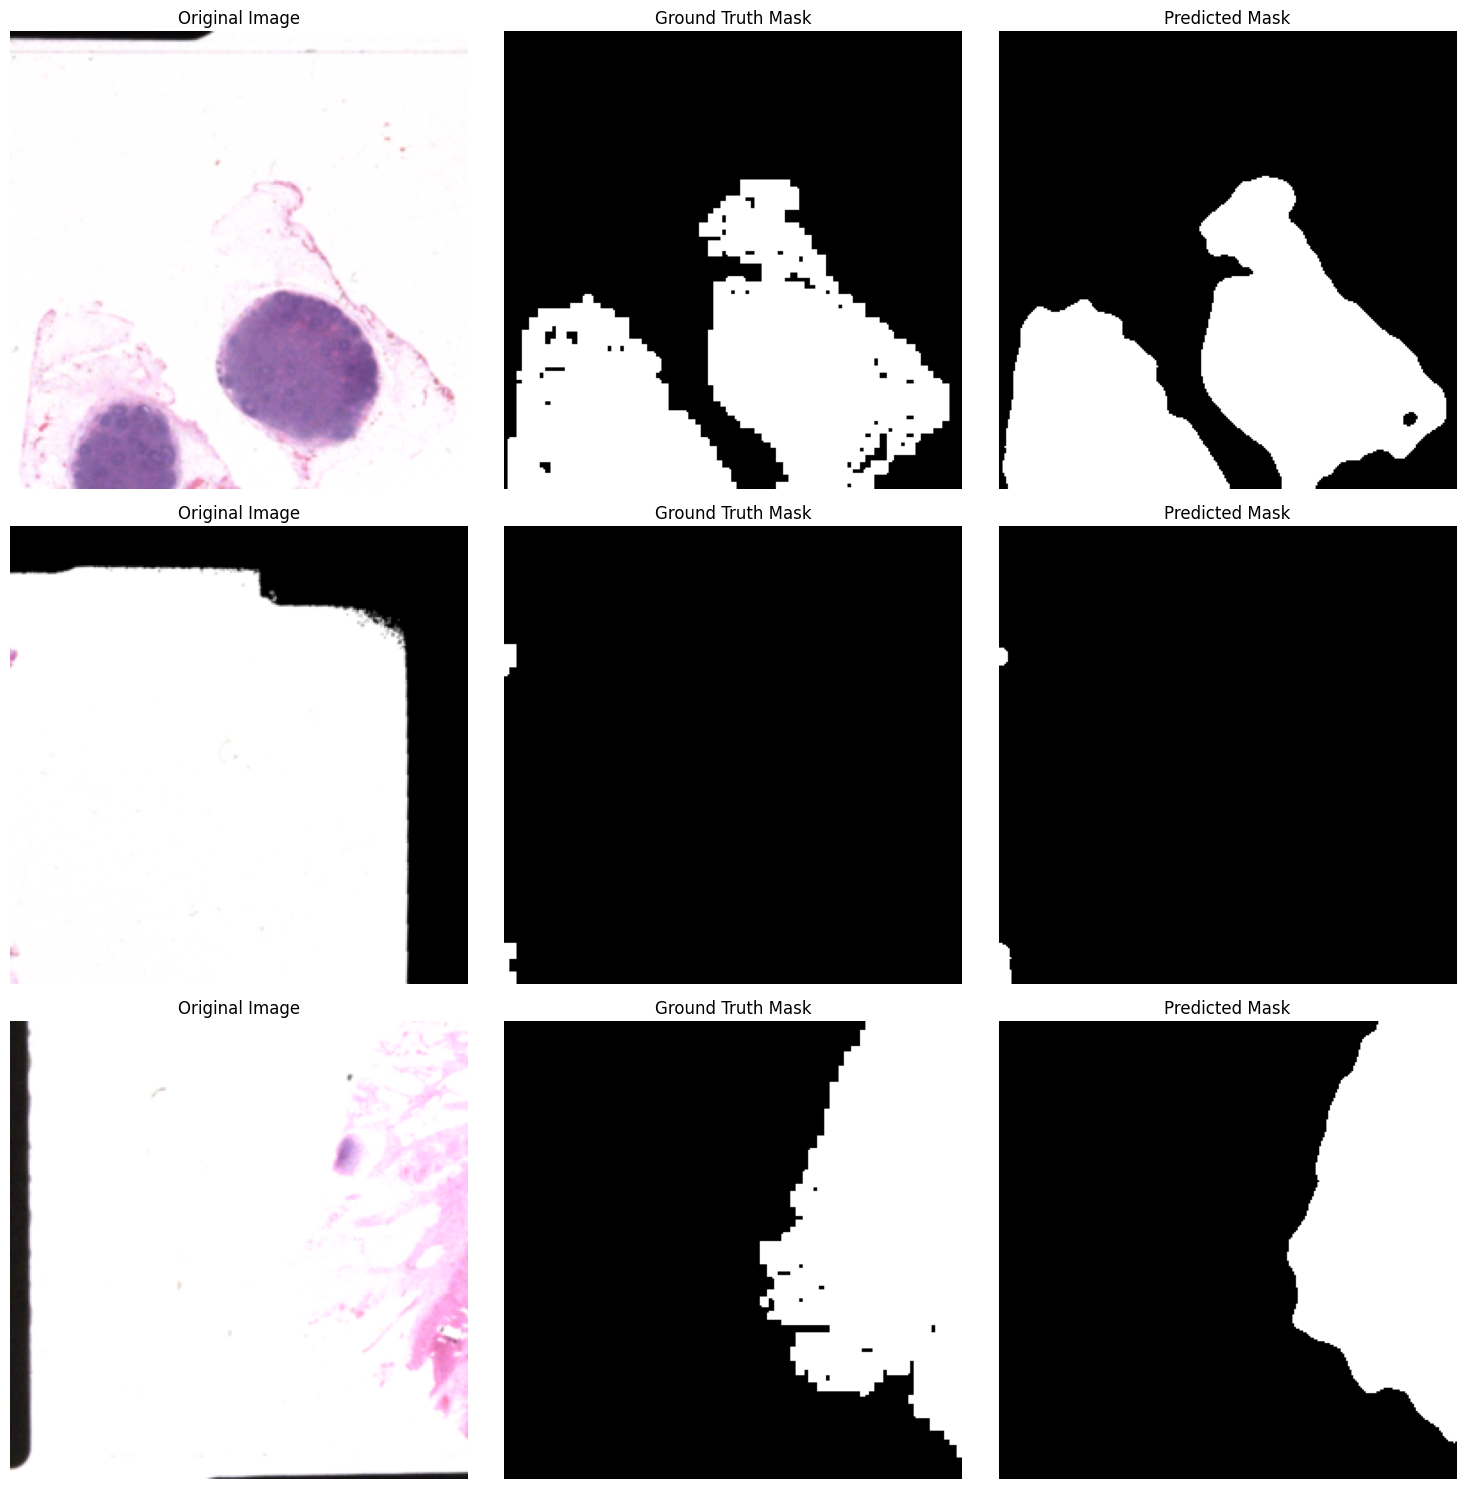

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
from pathlib import Path
import numpy as np
from tqdm import tqdm
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

class HuronDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = Path(image_dir)
        self.mask_dir = Path(mask_dir)
        self.transform = transform
        self.mask_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])
        self.images = sorted(os.listdir(image_dir))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.image_dir / self.images[idx]
        mask_path = self.mask_dir / self.images[idx]
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        
        if self.transform:
            image = self.transform(image)
        mask = self.mask_transform(mask)
        
        # Ensure mask is binary
        mask = (mask > 0.5).float()
        
        return image, mask

def calculate_iou(outputs, targets, threshold=0.5):
    outputs = (outputs > threshold).float()
    targets = targets.float()
    
    intersection = (outputs * targets).sum(dim=(1, 2))
    union = outputs.sum(dim=(1, 2)) + targets.sum(dim=(1, 2)) - intersection
    
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean()

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=3):
    best_val_iou = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_iou = 0.0
        
        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}') as pbar:
            for images, masks in pbar:
                images = images.to(device)
                masks = masks.to(device)
                
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, masks)
                iou = calculate_iou(outputs, masks)
                
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                running_iou += iou.item()
                
                pbar.set_postfix({
                    'loss': running_loss / (pbar.n + 1),
                    'IoU': running_iou / (pbar.n + 1)
                })
        
        # Validate
        model.eval()
        val_iou = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                outputs = model(images)
                val_iou += calculate_iou(outputs, masks).item()
        
        val_iou /= len(val_loader)
        print(f'Validation IoU: {val_iou:.4f}')
        
        if val_iou > best_val_iou:
            best_val_iou = val_iou
            torch.save(model.state_dict(), 'best_model.pth')

def visualize_results(model, test_loader, device, num_images=3):
    model.eval()
    
    # Get some test images
    test_images, test_masks = next(iter(test_loader))
    
    with torch.no_grad():
        test_images = test_images.to(device)
        predictions = model(test_images)
        predictions = (predictions > 0.5).float()
    
    # Convert tensors to numpy for visualization
    test_images = test_images.cpu()
    test_masks = test_masks.cpu()
    predictions = predictions.cpu()
    
    # Plot results
    fig, axes = plt.subplots(num_images, 3, figsize=(15, 5*num_images))
    
    for idx in range(num_images):
        # Original image
        img = test_images[idx].permute(1, 2, 0)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img = img.numpy()
        img = np.clip(img, 0, 1)
        
        # Ground truth mask
        mask = test_masks[idx].squeeze().numpy()
        
        # Predicted mask
        pred = predictions[idx].squeeze().numpy()
        
        # Plot
        axes[idx, 0].imshow(img)
        axes[idx, 0].set_title('Original Image')
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(mask, cmap='gray')
        axes[idx, 1].set_title('Ground Truth Mask')
        axes[idx, 1].axis('off')
        
        axes[idx, 2].imshow(pred, cmap='gray')
        axes[idx, 2].set_title('Predicted Mask')
        axes[idx, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Dataset paths
    image_dir = '/kaggle/input/huron-dataset/Sliced_Images'
    mask_dir = '/kaggle/input/huron-dataset/Sliced_masks'
    
    # Transform for input images
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Create full dataset
    full_dataset = HuronDataset(image_dir, mask_dir, transform=transform)
    
    # Calculate splits
    total_size = len(full_dataset)
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size
    
    # Split dataset
    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset, 
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)
    
    # Initialize model
    model = smp.UnetPlusPlus(
        encoder_name="resnet34",
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
        decoder_attention_type="scse"
    ).to(device)
    
    # Initialize loss and optimizer
    criterion = smp.losses.DiceLoss('binary')
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Train for 3 epochs
    train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=3)
    
    # Visualize results
    visualize_results(model, test_loader, device, num_images=3)

if __name__ == '__main__':
    main()

In [4]:

def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Dataset paths
    image_dir = '/kaggle/input/huron-dataset/Sliced_Images'
    mask_dir = '/kaggle/input/huron-dataset/Sliced_masks'
    
    # Transform for input images
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Create full dataset
    full_dataset = HuronDataset(image_dir, mask_dir, transform=transform)
    
    # Calculate splits
    total_size = len(full_dataset)
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size
    
    # Split dataset
    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset, 
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )
    
    print(f"Dataset splits: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)
    
    # Initialize model
    model = smp.Unet(
        encoder_name="resnet34",
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
    ).to(device)
    
    # Initialize loss and optimizer
    criterion = smp.losses.DiceLoss('binary')
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Train the model
    train_model(model, train_loader, val_loader, criterion, optimizer, device)
    
    # Evaluate on test set
    print("Evaluating on test set...")
    model.load_state_dict(torch.load('best_model.pth'))
    test_loss, test_iou = evaluate(model, test_loader, criterion, device)
    print(f'Test Loss: {test_loss:.4f}, Test IoU: {test_iou:.4f}')

if __name__ == '__main__':
    main()

Using device: cuda
Dataset splits: Train=12142, Val=2602, Test=2603


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 220MB/s] 
Epoch 1/20: 100%|██████████| 1518/1518 [02:59<00:00,  8.48it/s, loss=0.118, IoU=0.872]



Epoch 1/20:
Train Loss: 0.1176, Train IoU: 0.8717
Val Loss: 0.1148, Val IoU: 0.8599
New best model saved with IoU: 0.8599
------------------------------------------------------------


Epoch 2/20: 100%|██████████| 1518/1518 [03:04<00:00,  8.24it/s, loss=0.0971, IoU=0.889]



Epoch 2/20:
Train Loss: 0.0971, Train IoU: 0.8887
Val Loss: 0.1009, Val IoU: 0.8801
New best model saved with IoU: 0.8801
------------------------------------------------------------


Epoch 3/20: 100%|██████████| 1518/1518 [03:04<00:00,  8.22it/s, loss=0.0913, IoU=0.894]



Epoch 3/20:
Train Loss: 0.0913, Train IoU: 0.8944
Val Loss: 0.0809, Val IoU: 0.9014
New best model saved with IoU: 0.9014
------------------------------------------------------------


Epoch 4/20: 100%|██████████| 1518/1518 [03:04<00:00,  8.22it/s, loss=0.0854, IoU=0.899]



Epoch 4/20:
Train Loss: 0.0854, Train IoU: 0.8994
Val Loss: 0.0788, Val IoU: 0.9035
New best model saved with IoU: 0.9035
------------------------------------------------------------


Epoch 5/20: 100%|██████████| 1518/1518 [03:04<00:00,  8.22it/s, loss=0.0878, IoU=0.896]



Epoch 5/20:
Train Loss: 0.0878, Train IoU: 0.8965
Val Loss: 0.0874, Val IoU: 0.8957
------------------------------------------------------------


Epoch 6/20: 100%|██████████| 1518/1518 [03:04<00:00,  8.22it/s, loss=0.0836, IoU=0.902]



Epoch 6/20:
Train Loss: 0.0836, Train IoU: 0.9021
Val Loss: 0.0745, Val IoU: 0.9067
New best model saved with IoU: 0.9067
------------------------------------------------------------


Epoch 7/20: 100%|██████████| 1518/1518 [03:04<00:00,  8.22it/s, loss=0.0828, IoU=0.902]



Epoch 7/20:
Train Loss: 0.0828, Train IoU: 0.9015
Val Loss: 0.0779, Val IoU: 0.9038
------------------------------------------------------------


Epoch 8/20: 100%|██████████| 1518/1518 [03:04<00:00,  8.22it/s, loss=0.0823, IoU=0.901]



Epoch 8/20:
Train Loss: 0.0823, Train IoU: 0.9013
Val Loss: 0.0906, Val IoU: 0.8920
------------------------------------------------------------


Epoch 9/20: 100%|██████████| 1518/1518 [03:04<00:00,  8.22it/s, loss=0.0792, IoU=0.905]



Epoch 9/20:
Train Loss: 0.0792, Train IoU: 0.9050
Val Loss: 0.0961, Val IoU: 0.8899
------------------------------------------------------------


Epoch 10/20: 100%|██████████| 1518/1518 [03:04<00:00,  8.22it/s, loss=0.0802, IoU=0.904]



Epoch 10/20:
Train Loss: 0.0802, Train IoU: 0.9040
Val Loss: 0.0731, Val IoU: 0.9087
New best model saved with IoU: 0.9087
------------------------------------------------------------


Epoch 11/20: 100%|██████████| 1518/1518 [03:10<00:00,  7.96it/s, loss=0.0789, IoU=0.907]



Epoch 11/20:
Train Loss: 0.0789, Train IoU: 0.9065
Val Loss: 0.0825, Val IoU: 0.8982
------------------------------------------------------------


Epoch 12/20: 100%|██████████| 1518/1518 [03:04<00:00,  8.22it/s, loss=0.0798, IoU=0.905]



Epoch 12/20:
Train Loss: 0.0798, Train IoU: 0.9046
Val Loss: 0.0723, Val IoU: 0.9099
New best model saved with IoU: 0.9099
------------------------------------------------------------


Epoch 13/20: 100%|██████████| 1518/1518 [03:04<00:00,  8.22it/s, loss=0.0764, IoU=0.908]



Epoch 13/20:
Train Loss: 0.0764, Train IoU: 0.9076
Val Loss: 0.6376, Val IoU: 0.3400
------------------------------------------------------------


Epoch 14/20: 100%|██████████| 1518/1518 [03:04<00:00,  8.22it/s, loss=0.0736, IoU=0.909]



Epoch 14/20:
Train Loss: 0.0736, Train IoU: 0.9085
Val Loss: 0.0739, Val IoU: 0.9080
------------------------------------------------------------


Epoch 15/20: 100%|██████████| 1518/1518 [03:04<00:00,  8.22it/s, loss=0.0749, IoU=0.909]



Epoch 15/20:
Train Loss: 0.0749, Train IoU: 0.9085
Val Loss: 0.1084, Val IoU: 0.8793
------------------------------------------------------------


Epoch 16/20: 100%|██████████| 1518/1518 [03:04<00:00,  8.22it/s, loss=0.0739, IoU=0.909]



Epoch 16/20:
Train Loss: 0.0739, Train IoU: 0.9088
Val Loss: 0.0781, Val IoU: 0.9048
------------------------------------------------------------


Epoch 17/20: 100%|██████████| 1518/1518 [03:04<00:00,  8.22it/s, loss=0.0738, IoU=0.91] 



Epoch 17/20:
Train Loss: 0.0738, Train IoU: 0.9104
Val Loss: 0.0714, Val IoU: 0.9105
New best model saved with IoU: 0.9105
------------------------------------------------------------


Epoch 18/20: 100%|██████████| 1518/1518 [03:04<00:00,  8.22it/s, loss=0.075, IoU=0.909] 



Epoch 18/20:
Train Loss: 0.0750, Train IoU: 0.9093
Val Loss: 0.0707, Val IoU: 0.9103
------------------------------------------------------------


Epoch 19/20: 100%|██████████| 1518/1518 [03:04<00:00,  8.22it/s, loss=0.0749, IoU=0.91] 



Epoch 19/20:
Train Loss: 0.0749, Train IoU: 0.9100
Val Loss: 0.0772, Val IoU: 0.9042
------------------------------------------------------------


Epoch 20/20: 100%|██████████| 1518/1518 [03:04<00:00,  8.22it/s, loss=0.0731, IoU=0.911]



Epoch 20/20:
Train Loss: 0.0731, Train IoU: 0.9111
Val Loss: 0.0996, Val IoU: 0.8842
------------------------------------------------------------
Evaluating on test set...


/tmp/ipykernel_30/4073662263.py:190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test Loss: 0.0749, Test IoU: 0.9101


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
from pathlib import Path
import numpy as np
from tqdm import tqdm
import segmentation_models_pytorch as smp

# Previous Dataset and evaluation code remains the same...

def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Dataset paths
    image_dir = '/kaggle/input/huron-dataset/Sliced_Images'
    mask_dir = '/kaggle/input/huron-dataset/Sliced_masks'
    
    # Transform for input images
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Create full dataset
    full_dataset = HuronDataset(image_dir, mask_dir, transform=transform)
    
    # Calculate splits
    total_size = len(full_dataset)
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size
    
    # Split dataset
    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset, 
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )
    
    print(f"Dataset splits: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)
    
    # Model configuration
    encoder_name = "resnet34"
    
    # Initialize Attention U-Net model
    model = smp.UnetPlusPlus(
        encoder_name=encoder_name,        # try different encoders
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights
        in_channels=3,                  # model input channels
        classes=1,                      # model output channels
        decoder_attention_type="scse"   # spatial and channel squeeze & excitation
    ).to(device)
    
    print(f"Model: Attention U-Net++ with {encoder_name} encoder and SCSE attention")
    
    # Initialize loss and optimizer
    criterion = smp.losses.DiceLoss('binary')
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Train the model
    train_model(model, train_loader, val_loader, criterion, optimizer, device)
    
    # Evaluate on test set
    print("Evaluating on test set...")
    model.load_state_dict(torch.load('best_model.pth'))
    test_loss, test_iou = evaluate(model, test_loader, criterion, device)
    print(f'Test Loss: {test_loss:.4f}, Test IoU: {test_iou:.4f}')

if __name__ == '__main__':
    main()

Using device: cuda
Dataset splits: Train=12142, Val=2602, Test=2603


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 356MB/s]


Model: Attention U-Net++ with resnet34 encoder and SCSE attention


Epoch 1/20: 100%|██████████| 1518/1518 [08:28<00:00,  2.99it/s, loss=0.12, IoU=0.872] 



Epoch 1/20:
Train Loss: 0.1195, Train IoU: 0.8721
Val Loss: 0.1255, Val IoU: 0.8512
New best model saved with IoU: 0.8512
------------------------------------------------------------


Epoch 2/20: 100%|██████████| 1518/1518 [08:32<00:00,  2.96it/s, loss=0.088, IoU=0.895] 



Epoch 2/20:
Train Loss: 0.0880, Train IoU: 0.8953
Val Loss: 0.0875, Val IoU: 0.8958
New best model saved with IoU: 0.8958
------------------------------------------------------------


Epoch 3/20: 100%|██████████| 1518/1518 [08:31<00:00,  2.97it/s, loss=0.0854, IoU=0.899]



Epoch 3/20:
Train Loss: 0.0854, Train IoU: 0.8985
Val Loss: 0.0928, Val IoU: 0.8895
------------------------------------------------------------


Epoch 4/20: 100%|██████████| 1518/1518 [08:31<00:00,  2.97it/s, loss=0.0879, IoU=0.896]



Epoch 4/20:
Train Loss: 0.0879, Train IoU: 0.8963
Val Loss: 0.0755, Val IoU: 0.9063
New best model saved with IoU: 0.9063
------------------------------------------------------------


Epoch 5/20: 100%|██████████| 1518/1518 [08:31<00:00,  2.97it/s, loss=0.0846, IoU=0.9]  



Epoch 5/20:
Train Loss: 0.0846, Train IoU: 0.8999
Val Loss: 0.0768, Val IoU: 0.9059
------------------------------------------------------------


Epoch 6/20: 100%|██████████| 1518/1518 [08:31<00:00,  2.97it/s, loss=0.0833, IoU=0.902]



Epoch 6/20:
Train Loss: 0.0833, Train IoU: 0.9018
Val Loss: 0.0810, Val IoU: 0.9011
------------------------------------------------------------


Epoch 7/20: 100%|██████████| 1518/1518 [08:31<00:00,  2.97it/s, loss=0.0798, IoU=0.904]



Epoch 7/20:
Train Loss: 0.0798, Train IoU: 0.9037
Val Loss: 0.0797, Val IoU: 0.9023
------------------------------------------------------------


Epoch 8/20: 100%|██████████| 1518/1518 [08:31<00:00,  2.97it/s, loss=0.083, IoU=0.901] 



Epoch 8/20:
Train Loss: 0.0830, Train IoU: 0.9008
Val Loss: 0.0780, Val IoU: 0.9040
------------------------------------------------------------


Epoch 9/20: 100%|██████████| 1518/1518 [08:31<00:00,  2.97it/s, loss=0.0771, IoU=0.906]



Epoch 9/20:
Train Loss: 0.0771, Train IoU: 0.9062
Val Loss: 0.0805, Val IoU: 0.9024
------------------------------------------------------------


Epoch 10/20: 100%|██████████| 1518/1518 [08:30<00:00,  2.97it/s, loss=0.0759, IoU=0.908]



Epoch 10/20:
Train Loss: 0.0759, Train IoU: 0.9084
Val Loss: 0.0949, Val IoU: 0.8909
------------------------------------------------------------


Epoch 11/20: 100%|██████████| 1518/1518 [08:31<00:00,  2.97it/s, loss=0.0753, IoU=0.909]



Epoch 11/20:
Train Loss: 0.0753, Train IoU: 0.9086
Val Loss: 0.0906, Val IoU: 0.8930
------------------------------------------------------------


Epoch 12/20: 100%|██████████| 1518/1518 [08:30<00:00,  2.97it/s, loss=0.0785, IoU=0.905]



Epoch 12/20:
Train Loss: 0.0785, Train IoU: 0.9054
Val Loss: 0.0743, Val IoU: 0.9078
New best model saved with IoU: 0.9078
------------------------------------------------------------


Epoch 13/20: 100%|██████████| 1518/1518 [08:31<00:00,  2.97it/s, loss=0.0762, IoU=0.907]



Epoch 13/20:
Train Loss: 0.0762, Train IoU: 0.9073
Val Loss: 0.0709, Val IoU: 0.9111
New best model saved with IoU: 0.9111
------------------------------------------------------------


Epoch 14/20: 100%|██████████| 1518/1518 [08:31<00:00,  2.97it/s, loss=0.0755, IoU=0.909]



Epoch 14/20:
Train Loss: 0.0755, Train IoU: 0.9088
Val Loss: 0.0760, Val IoU: 0.9067
------------------------------------------------------------


Epoch 15/20: 100%|██████████| 1518/1518 [08:31<00:00,  2.97it/s, loss=0.0743, IoU=0.91] 



Epoch 15/20:
Train Loss: 0.0743, Train IoU: 0.9097
Val Loss: 0.0710, Val IoU: 0.9108
------------------------------------------------------------


Epoch 16/20: 100%|██████████| 1518/1518 [08:31<00:00,  2.97it/s, loss=0.0721, IoU=0.911]



Epoch 16/20:
Train Loss: 0.0721, Train IoU: 0.9112
Val Loss: 0.0795, Val IoU: 0.9035
------------------------------------------------------------


Epoch 17/20: 100%|██████████| 1518/1518 [08:31<00:00,  2.97it/s, loss=0.0723, IoU=0.911]



Epoch 17/20:
Train Loss: 0.0723, Train IoU: 0.9112
Val Loss: 0.0695, Val IoU: 0.9121
New best model saved with IoU: 0.9121
------------------------------------------------------------


Epoch 18/20: 100%|██████████| 1518/1518 [08:31<00:00,  2.97it/s, loss=0.072, IoU=0.912] 



Epoch 18/20:
Train Loss: 0.0720, Train IoU: 0.9117
Val Loss: 0.0671, Val IoU: 0.9146
New best model saved with IoU: 0.9146
------------------------------------------------------------


Epoch 19/20: 100%|██████████| 1518/1518 [08:30<00:00,  2.97it/s, loss=0.0722, IoU=0.912]



Epoch 19/20:
Train Loss: 0.0722, Train IoU: 0.9121
Val Loss: 0.0687, Val IoU: 0.9129
------------------------------------------------------------


Epoch 20/20: 100%|██████████| 1518/1518 [08:31<00:00,  2.97it/s, loss=0.0711, IoU=0.912]



Epoch 20/20:
Train Loss: 0.0711, Train IoU: 0.9123
Val Loss: 0.0737, Val IoU: 0.9090
------------------------------------------------------------
Evaluating on test set...


/tmp/ipykernel_30/2309762530.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test Loss: 0.0714, Test IoU: 0.9132


In [11]:
pip install transformers 

Note: you may need to restart the kernel to use updated packages.


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
from pathlib import Path
import numpy as np
from tqdm import tqdm
from transformers import SegformerForSemanticSegmentation
import torch.nn.functional as F

class HuronDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = Path(image_dir)
        self.mask_dir = Path(mask_dir)
        self.transform = transform
        self.mask_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])
        self.images = sorted(os.listdir(image_dir))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.image_dir / self.images[idx]
        mask_path = self.mask_dir / self.images[idx]
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        
        if self.transform:
            image = self.transform(image)
        mask = self.mask_transform(mask)
        
        # Ensure mask is binary and remove channel dimension
        mask = (mask > 0.5).float().squeeze(0)
        
        return image, mask

def calculate_iou(outputs, targets, threshold=0.5):
    # Ensure outputs and targets have the same size
    if outputs.size() != targets.size():
        outputs = F.interpolate(outputs.unsqueeze(1), size=targets.size()[-2:], mode='bilinear', align_corners=False)
        outputs = outputs.squeeze(1)
    
    outputs = (outputs > threshold).float()
    targets = targets.float()
    
    intersection = (outputs * targets).sum(dim=(1, 2))
    union = outputs.sum(dim=(1, 2)) + targets.sum(dim=(1, 2)) - intersection
    
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean()

def evaluate(model, dataloader, device):
    model.eval()
    total_iou = 0
    num_batches = len(dataloader)
    
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            
            # Get model outputs
            outputs = model(images).logits
            
            # Resize outputs to match mask size
            outputs = F.interpolate(outputs, size=masks.shape[-2:], mode='bilinear', align_corners=False)
            
            # Get the tissue class probabilities (class 1)
            outputs = torch.softmax(outputs, dim=1)[:, 1]
            
            # Calculate IoU
            iou = calculate_iou(outputs, masks)
            
            total_iou += iou.item()
    
    return total_iou / num_batches

def train_model(model, train_loader, val_loader, optimizer, device, num_epochs=5):
    best_val_iou = 0
    criterion = smp.losses.DiceLoss('binary')  # Add explicit Dice Loss
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_iou = 0.0
        
        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}') as pbar:
            for images, masks in pbar:
                images = images.to(device)
                masks = masks.to(device)
                
                optimizer.zero_grad()
                
                # Forward pass without computing internal loss
                outputs = model(pixel_values=images)
                logits = outputs.logits
                
                # Resize logits to match mask size
                logits = F.interpolate(logits, size=masks.shape[-2:], mode='bilinear', align_corners=False)
                
                # Get the tissue class probabilities (class 1)
                probs = torch.softmax(logits, dim=1)[:, 1]
                
                # Calculate Dice Loss
                loss = criterion(probs, masks)
                
                # Calculate IoU
                iou = calculate_iou(probs, masks)
                
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                running_iou += iou.item()
                
                pbar.set_postfix({
                    'loss': running_loss / (pbar.n + 1),
                    'IoU': running_iou / (pbar.n + 1)
                })
        
        # Rest of the code remains the same...

def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Dataset paths
    image_dir = '/kaggle/input/huron-dataset/Sliced_Images'
    mask_dir = '/kaggle/input/huron-dataset/Sliced_masks'
    
    # Transform for input images
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Create full dataset
    full_dataset = HuronDataset(image_dir, mask_dir, transform=transform)
    
    # Calculate splits
    total_size = len(full_dataset)
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size
    
    # Split dataset
    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset, 
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )
    
    print(f"Dataset splits: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)
    
    # Initialize Segformer model
    model = SegformerForSemanticSegmentation.from_pretrained(
        "nvidia/mit-b0",
        num_labels=2,  # background and tissue
        id2label={0: "background", 1: "tissue"},
        label2id={"background": 0, "tissue": 1},
        ignore_mismatched_sizes=True,
    ).to(device)
    
    print("Model: Segformer-B0")
    
    # Initialize optimizer
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)
    
    # Train the model
    train_model(model, train_loader, val_loader, optimizer, device)
    
    # Evaluate on test set
    print("Evaluating on test set...")
    model.load_state_dict(torch.load('best_model.pth'))
    test_iou = evaluate(model, test_loader, device)
    print(f'Test IoU: {test_iou:.4f}')

if __name__ == '__main__':
    main()

Using device: cuda
Dataset splits: Train=12142, Val=2602, Test=2603


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: Segformer-B0


Epoch 5/5: 100%|██████████| 1518/1518 [02:02<00:00, 12.43it/s, loss=0.655, IoU=0.765]
/tmp/ipykernel_30/986568814.py:189: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model

Evaluating on test set...


RuntimeError: Error(s) in loading state_dict for SegformerForSemanticSegmentation:
	Missing key(s) in state_dict: "segformer.encoder.patch_embeddings.0.proj.weight", "segformer.encoder.patch_embeddings.0.proj.bias", "segformer.encoder.patch_embeddings.0.layer_norm.weight", "segformer.encoder.patch_embeddings.0.layer_norm.bias", "segformer.encoder.patch_embeddings.1.proj.weight", "segformer.encoder.patch_embeddings.1.proj.bias", "segformer.encoder.patch_embeddings.1.layer_norm.weight", "segformer.encoder.patch_embeddings.1.layer_norm.bias", "segformer.encoder.patch_embeddings.2.proj.weight", "segformer.encoder.patch_embeddings.2.proj.bias", "segformer.encoder.patch_embeddings.2.layer_norm.weight", "segformer.encoder.patch_embeddings.2.layer_norm.bias", "segformer.encoder.patch_embeddings.3.proj.weight", "segformer.encoder.patch_embeddings.3.proj.bias", "segformer.encoder.patch_embeddings.3.layer_norm.weight", "segformer.encoder.patch_embeddings.3.layer_norm.bias", "segformer.encoder.block.0.0.layer_norm_1.weight", "segformer.encoder.block.0.0.layer_norm_1.bias", "segformer.encoder.block.0.0.attention.self.query.weight", "segformer.encoder.block.0.0.attention.self.query.bias", "segformer.encoder.block.0.0.attention.self.key.weight", "segformer.encoder.block.0.0.attention.self.key.bias", "segformer.encoder.block.0.0.attention.self.value.weight", "segformer.encoder.block.0.0.attention.self.value.bias", "segformer.encoder.block.0.0.attention.self.sr.weight", "segformer.encoder.block.0.0.attention.self.sr.bias", "segformer.encoder.block.0.0.attention.self.layer_norm.weight", "segformer.encoder.block.0.0.attention.self.layer_norm.bias", "segformer.encoder.block.0.0.attention.output.dense.weight", "segformer.encoder.block.0.0.attention.output.dense.bias", "segformer.encoder.block.0.0.layer_norm_2.weight", "segformer.encoder.block.0.0.layer_norm_2.bias", "segformer.encoder.block.0.0.mlp.dense1.weight", "segformer.encoder.block.0.0.mlp.dense1.bias", "segformer.encoder.block.0.0.mlp.dwconv.dwconv.weight", "segformer.encoder.block.0.0.mlp.dwconv.dwconv.bias", "segformer.encoder.block.0.0.mlp.dense2.weight", "segformer.encoder.block.0.0.mlp.dense2.bias", "segformer.encoder.block.0.1.layer_norm_1.weight", "segformer.encoder.block.0.1.layer_norm_1.bias", "segformer.encoder.block.0.1.attention.self.query.weight", "segformer.encoder.block.0.1.attention.self.query.bias", "segformer.encoder.block.0.1.attention.self.key.weight", "segformer.encoder.block.0.1.attention.self.key.bias", "segformer.encoder.block.0.1.attention.self.value.weight", "segformer.encoder.block.0.1.attention.self.value.bias", "segformer.encoder.block.0.1.attention.self.sr.weight", "segformer.encoder.block.0.1.attention.self.sr.bias", "segformer.encoder.block.0.1.attention.self.layer_norm.weight", "segformer.encoder.block.0.1.attention.self.layer_norm.bias", "segformer.encoder.block.0.1.attention.output.dense.weight", "segformer.encoder.block.0.1.attention.output.dense.bias", "segformer.encoder.block.0.1.layer_norm_2.weight", "segformer.encoder.block.0.1.layer_norm_2.bias", "segformer.encoder.block.0.1.mlp.dense1.weight", "segformer.encoder.block.0.1.mlp.dense1.bias", "segformer.encoder.block.0.1.mlp.dwconv.dwconv.weight", "segformer.encoder.block.0.1.mlp.dwconv.dwconv.bias", "segformer.encoder.block.0.1.mlp.dense2.weight", "segformer.encoder.block.0.1.mlp.dense2.bias", "segformer.encoder.block.1.0.layer_norm_1.weight", "segformer.encoder.block.1.0.layer_norm_1.bias", "segformer.encoder.block.1.0.attention.self.query.weight", "segformer.encoder.block.1.0.attention.self.query.bias", "segformer.encoder.block.1.0.attention.self.key.weight", "segformer.encoder.block.1.0.attention.self.key.bias", "segformer.encoder.block.1.0.attention.self.value.weight", "segformer.encoder.block.1.0.attention.self.value.bias", "segformer.encoder.block.1.0.attention.self.sr.weight", "segformer.encoder.block.1.0.attention.self.sr.bias", "segformer.encoder.block.1.0.attention.self.layer_norm.weight", "segformer.encoder.block.1.0.attention.self.layer_norm.bias", "segformer.encoder.block.1.0.attention.output.dense.weight", "segformer.encoder.block.1.0.attention.output.dense.bias", "segformer.encoder.block.1.0.layer_norm_2.weight", "segformer.encoder.block.1.0.layer_norm_2.bias", "segformer.encoder.block.1.0.mlp.dense1.weight", "segformer.encoder.block.1.0.mlp.dense1.bias", "segformer.encoder.block.1.0.mlp.dwconv.dwconv.weight", "segformer.encoder.block.1.0.mlp.dwconv.dwconv.bias", "segformer.encoder.block.1.0.mlp.dense2.weight", "segformer.encoder.block.1.0.mlp.dense2.bias", "segformer.encoder.block.1.1.layer_norm_1.weight", "segformer.encoder.block.1.1.layer_norm_1.bias", "segformer.encoder.block.1.1.attention.self.query.weight", "segformer.encoder.block.1.1.attention.self.query.bias", "segformer.encoder.block.1.1.attention.self.key.weight", "segformer.encoder.block.1.1.attention.self.key.bias", "segformer.encoder.block.1.1.attention.self.value.weight", "segformer.encoder.block.1.1.attention.self.value.bias", "segformer.encoder.block.1.1.attention.self.sr.weight", "segformer.encoder.block.1.1.attention.self.sr.bias", "segformer.encoder.block.1.1.attention.self.layer_norm.weight", "segformer.encoder.block.1.1.attention.self.layer_norm.bias", "segformer.encoder.block.1.1.attention.output.dense.weight", "segformer.encoder.block.1.1.attention.output.dense.bias", "segformer.encoder.block.1.1.layer_norm_2.weight", "segformer.encoder.block.1.1.layer_norm_2.bias", "segformer.encoder.block.1.1.mlp.dense1.weight", "segformer.encoder.block.1.1.mlp.dense1.bias", "segformer.encoder.block.1.1.mlp.dwconv.dwconv.weight", "segformer.encoder.block.1.1.mlp.dwconv.dwconv.bias", "segformer.encoder.block.1.1.mlp.dense2.weight", "segformer.encoder.block.1.1.mlp.dense2.bias", "segformer.encoder.block.2.0.layer_norm_1.weight", "segformer.encoder.block.2.0.layer_norm_1.bias", "segformer.encoder.block.2.0.attention.self.query.weight", "segformer.encoder.block.2.0.attention.self.query.bias", "segformer.encoder.block.2.0.attention.self.key.weight", "segformer.encoder.block.2.0.attention.self.key.bias", "segformer.encoder.block.2.0.attention.self.value.weight", "segformer.encoder.block.2.0.attention.self.value.bias", "segformer.encoder.block.2.0.attention.self.sr.weight", "segformer.encoder.block.2.0.attention.self.sr.bias", "segformer.encoder.block.2.0.attention.self.layer_norm.weight", "segformer.encoder.block.2.0.attention.self.layer_norm.bias", "segformer.encoder.block.2.0.attention.output.dense.weight", "segformer.encoder.block.2.0.attention.output.dense.bias", "segformer.encoder.block.2.0.layer_norm_2.weight", "segformer.encoder.block.2.0.layer_norm_2.bias", "segformer.encoder.block.2.0.mlp.dense1.weight", "segformer.encoder.block.2.0.mlp.dense1.bias", "segformer.encoder.block.2.0.mlp.dwconv.dwconv.weight", "segformer.encoder.block.2.0.mlp.dwconv.dwconv.bias", "segformer.encoder.block.2.0.mlp.dense2.weight", "segformer.encoder.block.2.0.mlp.dense2.bias", "segformer.encoder.block.2.1.layer_norm_1.weight", "segformer.encoder.block.2.1.layer_norm_1.bias", "segformer.encoder.block.2.1.attention.self.query.weight", "segformer.encoder.block.2.1.attention.self.query.bias", "segformer.encoder.block.2.1.attention.self.key.weight", "segformer.encoder.block.2.1.attention.self.key.bias", "segformer.encoder.block.2.1.attention.self.value.weight", "segformer.encoder.block.2.1.attention.self.value.bias", "segformer.encoder.block.2.1.attention.self.sr.weight", "segformer.encoder.block.2.1.attention.self.sr.bias", "segformer.encoder.block.2.1.attention.self.layer_norm.weight", "segformer.encoder.block.2.1.attention.self.layer_norm.bias", "segformer.encoder.block.2.1.attention.output.dense.weight", "segformer.encoder.block.2.1.attention.output.dense.bias", "segformer.encoder.block.2.1.layer_norm_2.weight", "segformer.encoder.block.2.1.layer_norm_2.bias", "segformer.encoder.block.2.1.mlp.dense1.weight", "segformer.encoder.block.2.1.mlp.dense1.bias", "segformer.encoder.block.2.1.mlp.dwconv.dwconv.weight", "segformer.encoder.block.2.1.mlp.dwconv.dwconv.bias", "segformer.encoder.block.2.1.mlp.dense2.weight", "segformer.encoder.block.2.1.mlp.dense2.bias", "segformer.encoder.block.3.0.layer_norm_1.weight", "segformer.encoder.block.3.0.layer_norm_1.bias", "segformer.encoder.block.3.0.attention.self.query.weight", "segformer.encoder.block.3.0.attention.self.query.bias", "segformer.encoder.block.3.0.attention.self.key.weight", "segformer.encoder.block.3.0.attention.self.key.bias", "segformer.encoder.block.3.0.attention.self.value.weight", "segformer.encoder.block.3.0.attention.self.value.bias", "segformer.encoder.block.3.0.attention.output.dense.weight", "segformer.encoder.block.3.0.attention.output.dense.bias", "segformer.encoder.block.3.0.layer_norm_2.weight", "segformer.encoder.block.3.0.layer_norm_2.bias", "segformer.encoder.block.3.0.mlp.dense1.weight", "segformer.encoder.block.3.0.mlp.dense1.bias", "segformer.encoder.block.3.0.mlp.dwconv.dwconv.weight", "segformer.encoder.block.3.0.mlp.dwconv.dwconv.bias", "segformer.encoder.block.3.0.mlp.dense2.weight", "segformer.encoder.block.3.0.mlp.dense2.bias", "segformer.encoder.block.3.1.layer_norm_1.weight", "segformer.encoder.block.3.1.layer_norm_1.bias", "segformer.encoder.block.3.1.attention.self.query.weight", "segformer.encoder.block.3.1.attention.self.query.bias", "segformer.encoder.block.3.1.attention.self.key.weight", "segformer.encoder.block.3.1.attention.self.key.bias", "segformer.encoder.block.3.1.attention.self.value.weight", "segformer.encoder.block.3.1.attention.self.value.bias", "segformer.encoder.block.3.1.attention.output.dense.weight", "segformer.encoder.block.3.1.attention.output.dense.bias", "segformer.encoder.block.3.1.layer_norm_2.weight", "segformer.encoder.block.3.1.layer_norm_2.bias", "segformer.encoder.block.3.1.mlp.dense1.weight", "segformer.encoder.block.3.1.mlp.dense1.bias", "segformer.encoder.block.3.1.mlp.dwconv.dwconv.weight", "segformer.encoder.block.3.1.mlp.dwconv.dwconv.bias", "segformer.encoder.block.3.1.mlp.dense2.weight", "segformer.encoder.block.3.1.mlp.dense2.bias", "segformer.encoder.layer_norm.0.weight", "segformer.encoder.layer_norm.0.bias", "segformer.encoder.layer_norm.1.weight", "segformer.encoder.layer_norm.1.bias", "segformer.encoder.layer_norm.2.weight", "segformer.encoder.layer_norm.2.bias", "segformer.encoder.layer_norm.3.weight", "segformer.encoder.layer_norm.3.bias", "decode_head.linear_c.0.proj.weight", "decode_head.linear_c.0.proj.bias", "decode_head.linear_c.1.proj.weight", "decode_head.linear_c.1.proj.bias", "decode_head.linear_c.2.proj.weight", "decode_head.linear_c.2.proj.bias", "decode_head.linear_c.3.proj.weight", "decode_head.linear_c.3.proj.bias", "decode_head.linear_fuse.weight", "decode_head.batch_norm.weight", "decode_head.batch_norm.bias", "decode_head.batch_norm.running_mean", "decode_head.batch_norm.running_var", "decode_head.classifier.weight", "decode_head.classifier.bias". 
	Unexpected key(s) in state_dict: "encoder._conv_stem.weight", "encoder._bn0.weight", "encoder._bn0.bias", "encoder._bn0.running_mean", "encoder._bn0.running_var", "encoder._bn0.num_batches_tracked", "encoder._blocks.0._depthwise_conv.weight", "encoder._blocks.0._bn1.weight", "encoder._blocks.0._bn1.bias", "encoder._blocks.0._bn1.running_mean", "encoder._blocks.0._bn1.running_var", "encoder._blocks.0._bn1.num_batches_tracked", "encoder._blocks.0._se_reduce.weight", "encoder._blocks.0._se_reduce.bias", "encoder._blocks.0._se_expand.weight", "encoder._blocks.0._se_expand.bias", "encoder._blocks.0._project_conv.weight", "encoder._blocks.0._bn2.weight", "encoder._blocks.0._bn2.bias", "encoder._blocks.0._bn2.running_mean", "encoder._blocks.0._bn2.running_var", "encoder._blocks.0._bn2.num_batches_tracked", "encoder._blocks.1._depthwise_conv.weight", "encoder._blocks.1._bn1.weight", "encoder._blocks.1._bn1.bias", "encoder._blocks.1._bn1.running_mean", "encoder._blocks.1._bn1.running_var", "encoder._blocks.1._bn1.num_batches_tracked", "encoder._blocks.1._se_reduce.weight", "encoder._blocks.1._se_reduce.bias", "encoder._blocks.1._se_expand.weight", "encoder._blocks.1._se_expand.bias", "encoder._blocks.1._project_conv.weight", "encoder._blocks.1._bn2.weight", "encoder._blocks.1._bn2.bias", "encoder._blocks.1._bn2.running_mean", "encoder._blocks.1._bn2.running_var", "encoder._blocks.1._bn2.num_batches_tracked", "encoder._blocks.2._expand_conv.weight", "encoder._blocks.2._bn0.weight", "encoder._blocks.2._bn0.bias", "encoder._blocks.2._bn0.running_mean", "encoder._blocks.2._bn0.running_var", "encoder._blocks.2._bn0.num_batches_tracked", "encoder._blocks.2._depthwise_conv.weight", "encoder._blocks.2._bn1.weight", "encoder._blocks.2._bn1.bias", "encoder._blocks.2._bn1.running_mean", "encoder._blocks.2._bn1.running_var", "encoder._blocks.2._bn1.num_batches_tracked", "encoder._blocks.2._se_reduce.weight", "encoder._blocks.2._se_reduce.bias", "encoder._blocks.2._se_expand.weight", "encoder._blocks.2._se_expand.bias", "encoder._blocks.2._project_conv.weight", "encoder._blocks.2._bn2.weight", "encoder._blocks.2._bn2.bias", "encoder._blocks.2._bn2.running_mean", "encoder._blocks.2._bn2.running_var", "encoder._blocks.2._bn2.num_batches_tracked", "encoder._blocks.3._expand_conv.weight", "encoder._blocks.3._bn0.weight", "encoder._blocks.3._bn0.bias", "encoder._blocks.3._bn0.running_mean", "encoder._blocks.3._bn0.running_var", "encoder._blocks.3._bn0.num_batches_tracked", "encoder._blocks.3._depthwise_conv.weight", "encoder._blocks.3._bn1.weight", "encoder._blocks.3._bn1.bias", "encoder._blocks.3._bn1.running_mean", "encoder._blocks.3._bn1.running_var", "encoder._blocks.3._bn1.num_batches_tracked", "encoder._blocks.3._se_reduce.weight", "encoder._blocks.3._se_reduce.bias", "encoder._blocks.3._se_expand.weight", "encoder._blocks.3._se_expand.bias", "encoder._blocks.3._project_conv.weight", "encoder._blocks.3._bn2.weight", "encoder._blocks.3._bn2.bias", "encoder._blocks.3._bn2.running_mean", "encoder._blocks.3._bn2.running_var", "encoder._blocks.3._bn2.num_batches_tracked", "encoder._blocks.4._expand_conv.weight", "encoder._blocks.4._bn0.weight", "encoder._blocks.4._bn0.bias", "encoder._blocks.4._bn0.running_mean", "encoder._blocks.4._bn0.running_var", "encoder._blocks.4._bn0.num_batches_tracked", "encoder._blocks.4._depthwise_conv.weight", "encoder._blocks.4._bn1.weight", "encoder._blocks.4._bn1.bias", "encoder._blocks.4._bn1.running_mean", "encoder._blocks.4._bn1.running_var", "encoder._blocks.4._bn1.num_batches_tracked", "encoder._blocks.4._se_reduce.weight", "encoder._blocks.4._se_reduce.bias", "encoder._blocks.4._se_expand.weight", "encoder._blocks.4._se_expand.bias", "encoder._blocks.4._project_conv.weight", "encoder._blocks.4._bn2.weight", "encoder._blocks.4._bn2.bias", "encoder._blocks.4._bn2.running_mean", "encoder._blocks.4._bn2.running_var", "encoder._blocks.4._bn2.num_batches_tracked", "encoder._blocks.5._expand_conv.weight", "encoder._blocks.5._bn0.weight", "encoder._blocks.5._bn0.bias", "encoder._blocks.5._bn0.running_mean", "encoder._blocks.5._bn0.running_var", "encoder._blocks.5._bn0.num_batches_tracked", "encoder._blocks.5._depthwise_conv.weight", "encoder._blocks.5._bn1.weight", "encoder._blocks.5._bn1.bias", "encoder._blocks.5._bn1.running_mean", "encoder._blocks.5._bn1.running_var", "encoder._blocks.5._bn1.num_batches_tracked", "encoder._blocks.5._se_reduce.weight", "encoder._blocks.5._se_reduce.bias", "encoder._blocks.5._se_expand.weight", "encoder._blocks.5._se_expand.bias", "encoder._blocks.5._project_conv.weight", "encoder._blocks.5._bn2.weight", "encoder._blocks.5._bn2.bias", "encoder._blocks.5._bn2.running_mean", "encoder._blocks.5._bn2.running_var", "encoder._blocks.5._bn2.num_batches_tracked", "encoder._blocks.6._expand_conv.weight", "encoder._blocks.6._bn0.weight", "encoder._blocks.6._bn0.bias", "encoder._blocks.6._bn0.running_mean", "encoder._blocks.6._bn0.running_var", "encoder._blocks.6._bn0.num_batches_tracked", "encoder._blocks.6._depthwise_conv.weight", "encoder._blocks.6._bn1.weight", "encoder._blocks.6._bn1.bias", "encoder._blocks.6._bn1.running_mean", "encoder._blocks.6._bn1.running_var", "encoder._blocks.6._bn1.num_batches_tracked", "encoder._blocks.6._se_reduce.weight", "encoder._blocks.6._se_reduce.bias", "encoder._blocks.6._se_expand.weight", "encoder._blocks.6._se_expand.bias", "encoder._blocks.6._project_conv.weight", "encoder._blocks.6._bn2.weight", "encoder._blocks.6._bn2.bias", "encoder._blocks.6._bn2.running_mean", "encoder._blocks.6._bn2.running_var", "encoder._blocks.6._bn2.num_batches_tracked", "encoder._blocks.7._expand_conv.weight", "encoder._blocks.7._bn0.weight", "encoder._blocks.7._bn0.bias", "encoder._blocks.7._bn0.running_mean", "encoder._blocks.7._bn0.running_var", "encoder._blocks.7._bn0.num_batches_tracked", "encoder._blocks.7._depthwise_conv.weight", "encoder._blocks.7._bn1.weight", "encoder._blocks.7._bn1.bias", "encoder._blocks.7._bn1.running_mean", "encoder._blocks.7._bn1.running_var", "encoder._blocks.7._bn1.num_batches_tracked", "encoder._blocks.7._se_reduce.weight", "encoder._blocks.7._se_reduce.bias", "encoder._blocks.7._se_expand.weight", "encoder._blocks.7._se_expand.bias", "encoder._blocks.7._project_conv.weight", "encoder._blocks.7._bn2.weight", "encoder._blocks.7._bn2.bias", "encoder._blocks.7._bn2.running_mean", "encoder._blocks.7._bn2.running_var", "encoder._blocks.7._bn2.num_batches_tracked", "encoder._blocks.8._expand_conv.weight", "encoder._blocks.8._bn0.weight", "encoder._blocks.8._bn0.bias", "encoder._blocks.8._bn0.running_mean", "encoder._blocks.8._bn0.running_var", "encoder._blocks.8._bn0.num_batches_tracked", "encoder._blocks.8._depthwise_conv.weight", "encoder._blocks.8._bn1.weight", "encoder._blocks.8._bn1.bias", "encoder._blocks.8._bn1.running_mean", "encoder._blocks.8._bn1.running_var", "encoder._blocks.8._bn1.num_batches_tracked", "encoder._blocks.8._se_reduce.weight", "encoder._blocks.8._se_reduce.bias", "encoder._blocks.8._se_expand.weight", "encoder._blocks.8._se_expand.bias", "encoder._blocks.8._project_conv.weight", "encoder._blocks.8._bn2.weight", "encoder._blocks.8._bn2.bias", "encoder._blocks.8._bn2.running_mean", "encoder._blocks.8._bn2.running_var", "encoder._blocks.8._bn2.num_batches_tracked", "encoder._blocks.9._expand_conv.weight", "encoder._blocks.9._bn0.weight", "encoder._blocks.9._bn0.bias", "encoder._blocks.9._bn0.running_mean", "encoder._blocks.9._bn0.running_var", "encoder._blocks.9._bn0.num_batches_tracked", "encoder._blocks.9._depthwise_conv.weight", "encoder._blocks.9._bn1.weight", "encoder._blocks.9._bn1.bias", "encoder._blocks.9._bn1.running_mean", "encoder._blocks.9._bn1.running_var", "encoder._blocks.9._bn1.num_batches_tracked", "encoder._blocks.9._se_reduce.weight", "encoder._blocks.9._se_reduce.bias", "encoder._blocks.9._se_expand.weight", "encoder._blocks.9._se_expand.bias", "encoder._blocks.9._project_conv.weight", "encoder._blocks.9._bn2.weight", "encoder._blocks.9._bn2.bias", "encoder._blocks.9._bn2.running_mean", "encoder._blocks.9._bn2.running_var", "encoder._blocks.9._bn2.num_batches_tracked", "encoder._blocks.10._expand_conv.weight", "encoder._blocks.10._bn0.weight", "encoder._blocks.10._bn0.bias", "encoder._blocks.10._bn0.running_mean", "encoder._blocks.10._bn0.running_var", "encoder._blocks.10._bn0.num_batches_tracked", "encoder._blocks.10._depthwise_conv.weight", "encoder._blocks.10._bn1.weight", "encoder._blocks.10._bn1.bias", "encoder._blocks.10._bn1.running_mean", "encoder._blocks.10._bn1.running_var", "encoder._blocks.10._bn1.num_batches_tracked", "encoder._blocks.10._se_reduce.weight", "encoder._blocks.10._se_reduce.bias", "encoder._blocks.10._se_expand.weight", "encoder._blocks.10._se_expand.bias", "encoder._blocks.10._project_conv.weight", "encoder._blocks.10._bn2.weight", "encoder._blocks.10._bn2.bias", "encoder._blocks.10._bn2.running_mean", "encoder._blocks.10._bn2.running_var", "encoder._blocks.10._bn2.num_batches_tracked", "encoder._blocks.11._expand_conv.weight", "encoder._blocks.11._bn0.weight", "encoder._blocks.11._bn0.bias", "encoder._blocks.11._bn0.running_mean", "encoder._blocks.11._bn0.running_var", "encoder._blocks.11._bn0.num_batches_tracked", "encoder._blocks.11._depthwise_conv.weight", "encoder._blocks.11._bn1.weight", "encoder._blocks.11._bn1.bias", "encoder._blocks.11._bn1.running_mean", "encoder._blocks.11._bn1.running_var", "encoder._blocks.11._bn1.num_batches_tracked", "encoder._blocks.11._se_reduce.weight", "encoder._blocks.11._se_reduce.bias", "encoder._blocks.11._se_expand.weight", "encoder._blocks.11._se_expand.bias", "encoder._blocks.11._project_conv.weight", "encoder._blocks.11._bn2.weight", "encoder._blocks.11._bn2.bias", "encoder._blocks.11._bn2.running_mean", "encoder._blocks.11._bn2.running_var", "encoder._blocks.11._bn2.num_batches_tracked", "encoder._blocks.12._expand_conv.weight", "encoder._blocks.12._bn0.weight", "encoder._blocks.12._bn0.bias", "encoder._blocks.12._bn0.running_mean", "encoder._blocks.12._bn0.running_var", "encoder._blocks.12._bn0.num_batches_tracked", "encoder._blocks.12._depthwise_conv.weight", "encoder._blocks.12._bn1.weight", "encoder._blocks.12._bn1.bias", "encoder._blocks.12._bn1.running_mean", "encoder._blocks.12._bn1.running_var", "encoder._blocks.12._bn1.num_batches_tracked", "encoder._blocks.12._se_reduce.weight", "encoder._blocks.12._se_reduce.bias", "encoder._blocks.12._se_expand.weight", "encoder._blocks.12._se_expand.bias", "encoder._blocks.12._project_conv.weight", "encoder._blocks.12._bn2.weight", "encoder._blocks.12._bn2.bias", "encoder._blocks.12._bn2.running_mean", "encoder._blocks.12._bn2.running_var", "encoder._blocks.12._bn2.num_batches_tracked", "encoder._blocks.13._expand_conv.weight", "encoder._blocks.13._bn0.weight", "encoder._blocks.13._bn0.bias", "encoder._blocks.13._bn0.running_mean", "encoder._blocks.13._bn0.running_var", "encoder._blocks.13._bn0.num_batches_tracked", "encoder._blocks.13._depthwise_conv.weight", "encoder._blocks.13._bn1.weight", "encoder._blocks.13._bn1.bias", "encoder._blocks.13._bn1.running_mean", "encoder._blocks.13._bn1.running_var", "encoder._blocks.13._bn1.num_batches_tracked", "encoder._blocks.13._se_reduce.weight", "encoder._blocks.13._se_reduce.bias", "encoder._blocks.13._se_expand.weight", "encoder._blocks.13._se_expand.bias", "encoder._blocks.13._project_conv.weight", "encoder._blocks.13._bn2.weight", "encoder._blocks.13._bn2.bias", "encoder._blocks.13._bn2.running_mean", "encoder._blocks.13._bn2.running_var", "encoder._blocks.13._bn2.num_batches_tracked", "encoder._blocks.14._expand_conv.weight", "encoder._blocks.14._bn0.weight", "encoder._blocks.14._bn0.bias", "encoder._blocks.14._bn0.running_mean", "encoder._blocks.14._bn0.running_var", "encoder._blocks.14._bn0.num_batches_tracked", "encoder._blocks.14._depthwise_conv.weight", "encoder._blocks.14._bn1.weight", "encoder._blocks.14._bn1.bias", "encoder._blocks.14._bn1.running_mean", "encoder._blocks.14._bn1.running_var", "encoder._blocks.14._bn1.num_batches_tracked", "encoder._blocks.14._se_reduce.weight", "encoder._blocks.14._se_reduce.bias", "encoder._blocks.14._se_expand.weight", "encoder._blocks.14._se_expand.bias", "encoder._blocks.14._project_conv.weight", "encoder._blocks.14._bn2.weight", "encoder._blocks.14._bn2.bias", "encoder._blocks.14._bn2.running_mean", "encoder._blocks.14._bn2.running_var", "encoder._blocks.14._bn2.num_batches_tracked", "encoder._blocks.15._expand_conv.weight", "encoder._blocks.15._bn0.weight", "encoder._blocks.15._bn0.bias", "encoder._blocks.15._bn0.running_mean", "encoder._blocks.15._bn0.running_var", "encoder._blocks.15._bn0.num_batches_tracked", "encoder._blocks.15._depthwise_conv.weight", "encoder._blocks.15._bn1.weight", "encoder._blocks.15._bn1.bias", "encoder._blocks.15._bn1.running_mean", "encoder._blocks.15._bn1.running_var", "encoder._blocks.15._bn1.num_batches_tracked", "encoder._blocks.15._se_reduce.weight", "encoder._blocks.15._se_reduce.bias", "encoder._blocks.15._se_expand.weight", "encoder._blocks.15._se_expand.bias", "encoder._blocks.15._project_conv.weight", "encoder._blocks.15._bn2.weight", "encoder._blocks.15._bn2.bias", "encoder._blocks.15._bn2.running_mean", "encoder._blocks.15._bn2.running_var", "encoder._blocks.15._bn2.num_batches_tracked", "encoder._blocks.16._expand_conv.weight", "encoder._blocks.16._bn0.weight", "encoder._blocks.16._bn0.bias", "encoder._blocks.16._bn0.running_mean", "encoder._blocks.16._bn0.running_var", "encoder._blocks.16._bn0.num_batches_tracked", "encoder._blocks.16._depthwise_conv.weight", "encoder._blocks.16._bn1.weight", "encoder._blocks.16._bn1.bias", "encoder._blocks.16._bn1.running_mean", "encoder._blocks.16._bn1.running_var", "encoder._blocks.16._bn1.num_batches_tracked", "encoder._blocks.16._se_reduce.weight", "encoder._blocks.16._se_reduce.bias", "encoder._blocks.16._se_expand.weight", "encoder._blocks.16._se_expand.bias", "encoder._blocks.16._project_conv.weight", "encoder._blocks.16._bn2.weight", "encoder._blocks.16._bn2.bias", "encoder._blocks.16._bn2.running_mean", "encoder._blocks.16._bn2.running_var", "encoder._blocks.16._bn2.num_batches_tracked", "encoder._blocks.17._expand_conv.weight", "encoder._blocks.17._bn0.weight", "encoder._blocks.17._bn0.bias", "encoder._blocks.17._bn0.running_mean", "encoder._blocks.17._bn0.running_var", "encoder._blocks.17._bn0.num_batches_tracked", "encoder._blocks.17._depthwise_conv.weight", "encoder._blocks.17._bn1.weight", "encoder._blocks.17._bn1.bias", "encoder._blocks.17._bn1.running_mean", "encoder._blocks.17._bn1.running_var", "encoder._blocks.17._bn1.num_batches_tracked", "encoder._blocks.17._se_reduce.weight", "encoder._blocks.17._se_reduce.bias", "encoder._blocks.17._se_expand.weight", "encoder._blocks.17._se_expand.bias", "encoder._blocks.17._project_conv.weight", "encoder._blocks.17._bn2.weight", "encoder._blocks.17._bn2.bias", "encoder._blocks.17._bn2.running_mean", "encoder._blocks.17._bn2.running_var", "encoder._blocks.17._bn2.num_batches_tracked", "encoder._blocks.18._expand_conv.weight", "encoder._blocks.18._bn0.weight", "encoder._blocks.18._bn0.bias", "encoder._blocks.18._bn0.running_mean", "encoder._blocks.18._bn0.running_var", "encoder._blocks.18._bn0.num_batches_tracked", "encoder._blocks.18._depthwise_conv.weight", "encoder._blocks.18._bn1.weight", "encoder._blocks.18._bn1.bias", "encoder._blocks.18._bn1.running_mean", "encoder._blocks.18._bn1.running_var", "encoder._blocks.18._bn1.num_batches_tracked", "encoder._blocks.18._se_reduce.weight", "encoder._blocks.18._se_reduce.bias", "encoder._blocks.18._se_expand.weight", "encoder._blocks.18._se_expand.bias", "encoder._blocks.18._project_conv.weight", "encoder._blocks.18._bn2.weight", "encoder._blocks.18._bn2.bias", "encoder._blocks.18._bn2.running_mean", "encoder._blocks.18._bn2.running_var", "encoder._blocks.18._bn2.num_batches_tracked", "encoder._blocks.19._expand_conv.weight", "encoder._blocks.19._bn0.weight", "encoder._blocks.19._bn0.bias", "encoder._blocks.19._bn0.running_mean", "encoder._blocks.19._bn0.running_var", "encoder._blocks.19._bn0.num_batches_tracked", "encoder._blocks.19._depthwise_conv.weight", "encoder._blocks.19._bn1.weight", "encoder._blocks.19._bn1.bias", "encoder._blocks.19._bn1.running_mean", "encoder._blocks.19._bn1.running_var", "encoder._blocks.19._bn1.num_batches_tracked", "encoder._blocks.19._se_reduce.weight", "encoder._blocks.19._se_reduce.bias", "encoder._blocks.19._se_expand.weight", "encoder._blocks.19._se_expand.bias", "encoder._blocks.19._project_conv.weight", "encoder._blocks.19._bn2.weight", "encoder._blocks.19._bn2.bias", "encoder._blocks.19._bn2.running_mean", "encoder._blocks.19._bn2.running_var", "encoder._blocks.19._bn2.num_batches_tracked", "encoder._blocks.20._expand_conv.weight", "encoder._blocks.20._bn0.weight", "encoder._blocks.20._bn0.bias", "encoder._blocks.20._bn0.running_mean", "encoder._blocks.20._bn0.running_var", "encoder._blocks.20._bn0.num_batches_tracked", "encoder._blocks.20._depthwise_conv.weight", "encoder._blocks.20._bn1.weight", "encoder._blocks.20._bn1.bias", "encoder._blocks.20._bn1.running_mean", "encoder._blocks.20._bn1.running_var", "encoder._blocks.20._bn1.num_batches_tracked", "encoder._blocks.20._se_reduce.weight", "encoder._blocks.20._se_reduce.bias", "encoder._blocks.20._se_expand.weight", "encoder._blocks.20._se_expand.bias", "encoder._blocks.20._project_conv.weight", "encoder._blocks.20._bn2.weight", "encoder._blocks.20._bn2.bias", "encoder._blocks.20._bn2.running_mean", "encoder._blocks.20._bn2.running_var", "encoder._blocks.20._bn2.num_batches_tracked", "encoder._blocks.21._expand_conv.weight", "encoder._blocks.21._bn0.weight", "encoder._blocks.21._bn0.bias", "encoder._blocks.21._bn0.running_mean", "encoder._blocks.21._bn0.running_var", "encoder._blocks.21._bn0.num_batches_tracked", "encoder._blocks.21._depthwise_conv.weight", "encoder._blocks.21._bn1.weight", "encoder._blocks.21._bn1.bias", "encoder._blocks.21._bn1.running_mean", "encoder._blocks.21._bn1.running_var", "encoder._blocks.21._bn1.num_batches_tracked", "encoder._blocks.21._se_reduce.weight", "encoder._blocks.21._se_reduce.bias", "encoder._blocks.21._se_expand.weight", "encoder._blocks.21._se_expand.bias", "encoder._blocks.21._project_conv.weight", "encoder._blocks.21._bn2.weight", "encoder._blocks.21._bn2.bias", "encoder._blocks.21._bn2.running_mean", "encoder._blocks.21._bn2.running_var", "encoder._blocks.21._bn2.num_batches_tracked", "encoder._blocks.22._expand_conv.weight", "encoder._blocks.22._bn0.weight", "encoder._blocks.22._bn0.bias", "encoder._blocks.22._bn0.running_mean", "encoder._blocks.22._bn0.running_var", "encoder._blocks.22._bn0.num_batches_tracked", "encoder._blocks.22._depthwise_conv.weight", "encoder._blocks.22._bn1.weight", "encoder._blocks.22._bn1.bias", "encoder._blocks.22._bn1.running_mean", "encoder._blocks.22._bn1.running_var", "encoder._blocks.22._bn1.num_batches_tracked", "encoder._blocks.22._se_reduce.weight", "encoder._blocks.22._se_reduce.bias", "encoder._blocks.22._se_expand.weight", "encoder._blocks.22._se_expand.bias", "encoder._blocks.22._project_conv.weight", "encoder._blocks.22._bn2.weight", "encoder._blocks.22._bn2.bias", "encoder._blocks.22._bn2.running_mean", "encoder._blocks.22._bn2.running_var", "encoder._blocks.22._bn2.num_batches_tracked", "encoder._blocks.23._expand_conv.weight", "encoder._blocks.23._bn0.weight", "encoder._blocks.23._bn0.bias", "encoder._blocks.23._bn0.running_mean", "encoder._blocks.23._bn0.running_var", "encoder._blocks.23._bn0.num_batches_tracked", "encoder._blocks.23._depthwise_conv.weight", "encoder._blocks.23._bn1.weight", "encoder._blocks.23._bn1.bias", "encoder._blocks.23._bn1.running_mean", "encoder._blocks.23._bn1.running_var", "encoder._blocks.23._bn1.num_batches_tracked", "encoder._blocks.23._se_reduce.weight", "encoder._blocks.23._se_reduce.bias", "encoder._blocks.23._se_expand.weight", "encoder._blocks.23._se_expand.bias", "encoder._blocks.23._project_conv.weight", "encoder._blocks.23._bn2.weight", "encoder._blocks.23._bn2.bias", "encoder._blocks.23._bn2.running_mean", "encoder._blocks.23._bn2.running_var", "encoder._blocks.23._bn2.num_batches_tracked", "encoder._blocks.24._expand_conv.weight", "encoder._blocks.24._bn0.weight", "encoder._blocks.24._bn0.bias", "encoder._blocks.24._bn0.running_mean", "encoder._blocks.24._bn0.running_var", "encoder._blocks.24._bn0.num_batches_tracked", "encoder._blocks.24._depthwise_conv.weight", "encoder._blocks.24._bn1.weight", "encoder._blocks.24._bn1.bias", "encoder._blocks.24._bn1.running_mean", "encoder._blocks.24._bn1.running_var", "encoder._blocks.24._bn1.num_batches_tracked", "encoder._blocks.24._se_reduce.weight", "encoder._blocks.24._se_reduce.bias", "encoder._blocks.24._se_expand.weight", "encoder._blocks.24._se_expand.bias", "encoder._blocks.24._project_conv.weight", "encoder._blocks.24._bn2.weight", "encoder._blocks.24._bn2.bias", "encoder._blocks.24._bn2.running_mean", "encoder._blocks.24._bn2.running_var", "encoder._blocks.24._bn2.num_batches_tracked", "encoder._blocks.25._expand_conv.weight", "encoder._blocks.25._bn0.weight", "encoder._blocks.25._bn0.bias", "encoder._blocks.25._bn0.running_mean", "encoder._blocks.25._bn0.running_var", "encoder._blocks.25._bn0.num_batches_tracked", "encoder._blocks.25._depthwise_conv.weight", "encoder._blocks.25._bn1.weight", "encoder._blocks.25._bn1.bias", "encoder._blocks.25._bn1.running_mean", "encoder._blocks.25._bn1.running_var", "encoder._blocks.25._bn1.num_batches_tracked", "encoder._blocks.25._se_reduce.weight", "encoder._blocks.25._se_reduce.bias", "encoder._blocks.25._se_expand.weight", "encoder._blocks.25._se_expand.bias", "encoder._blocks.25._project_conv.weight", "encoder._blocks.25._bn2.weight", "encoder._blocks.25._bn2.bias", "encoder._blocks.25._bn2.running_mean", "encoder._blocks.25._bn2.running_var", "encoder._blocks.25._bn2.num_batches_tracked", "encoder._blocks.26._expand_conv.weight", "encoder._blocks.26._bn0.weight", "encoder._blocks.26._bn0.bias", "encoder._blocks.26._bn0.running_mean", "encoder._blocks.26._bn0.running_var", "encoder._blocks.26._bn0.num_batches_tracked", "encoder._blocks.26._depthwise_conv.weight", "encoder._blocks.26._bn1.weight", "encoder._blocks.26._bn1.bias", "encoder._blocks.26._bn1.running_mean", "encoder._blocks.26._bn1.running_var", "encoder._blocks.26._bn1.num_batches_tracked", "encoder._blocks.26._se_reduce.weight", "encoder._blocks.26._se_reduce.bias", "encoder._blocks.26._se_expand.weight", "encoder._blocks.26._se_expand.bias", "encoder._blocks.26._project_conv.weight", "encoder._blocks.26._bn2.weight", "encoder._blocks.26._bn2.bias", "encoder._blocks.26._bn2.running_mean", "encoder._blocks.26._bn2.running_var", "encoder._blocks.26._bn2.num_batches_tracked", "encoder._blocks.27._expand_conv.weight", "encoder._blocks.27._bn0.weight", "encoder._blocks.27._bn0.bias", "encoder._blocks.27._bn0.running_mean", "encoder._blocks.27._bn0.running_var", "encoder._blocks.27._bn0.num_batches_tracked", "encoder._blocks.27._depthwise_conv.weight", "encoder._blocks.27._bn1.weight", "encoder._blocks.27._bn1.bias", "encoder._blocks.27._bn1.running_mean", "encoder._blocks.27._bn1.running_var", "encoder._blocks.27._bn1.num_batches_tracked", "encoder._blocks.27._se_reduce.weight", "encoder._blocks.27._se_reduce.bias", "encoder._blocks.27._se_expand.weight", "encoder._blocks.27._se_expand.bias", "encoder._blocks.27._project_conv.weight", "encoder._blocks.27._bn2.weight", "encoder._blocks.27._bn2.bias", "encoder._blocks.27._bn2.running_mean", "encoder._blocks.27._bn2.running_var", "encoder._blocks.27._bn2.num_batches_tracked", "encoder._blocks.28._expand_conv.weight", "encoder._blocks.28._bn0.weight", "encoder._blocks.28._bn0.bias", "encoder._blocks.28._bn0.running_mean", "encoder._blocks.28._bn0.running_var", "encoder._blocks.28._bn0.num_batches_tracked", "encoder._blocks.28._depthwise_conv.weight", "encoder._blocks.28._bn1.weight", "encoder._blocks.28._bn1.bias", "encoder._blocks.28._bn1.running_mean", "encoder._blocks.28._bn1.running_var", "encoder._blocks.28._bn1.num_batches_tracked", "encoder._blocks.28._se_reduce.weight", "encoder._blocks.28._se_reduce.bias", "encoder._blocks.28._se_expand.weight", "encoder._blocks.28._se_expand.bias", "encoder._blocks.28._project_conv.weight", "encoder._blocks.28._bn2.weight", "encoder._blocks.28._bn2.bias", "encoder._blocks.28._bn2.running_mean", "encoder._blocks.28._bn2.running_var", "encoder._blocks.28._bn2.num_batches_tracked", "encoder._blocks.29._expand_conv.weight", "encoder._blocks.29._bn0.weight", "encoder._blocks.29._bn0.bias", "encoder._blocks.29._bn0.running_mean", "encoder._blocks.29._bn0.running_var", "encoder._blocks.29._bn0.num_batches_tracked", "encoder._blocks.29._depthwise_conv.weight", "encoder._blocks.29._bn1.weight", "encoder._blocks.29._bn1.bias", "encoder._blocks.29._bn1.running_mean", "encoder._blocks.29._bn1.running_var", "encoder._blocks.29._bn1.num_batches_tracked", "encoder._blocks.29._se_reduce.weight", "encoder._blocks.29._se_reduce.bias", "encoder._blocks.29._se_expand.weight", "encoder._blocks.29._se_expand.bias", "encoder._blocks.29._project_conv.weight", "encoder._blocks.29._bn2.weight", "encoder._blocks.29._bn2.bias", "encoder._blocks.29._bn2.running_mean", "encoder._blocks.29._bn2.running_var", "encoder._blocks.29._bn2.num_batches_tracked", "encoder._blocks.30._expand_conv.weight", "encoder._blocks.30._bn0.weight", "encoder._blocks.30._bn0.bias", "encoder._blocks.30._bn0.running_mean", "encoder._blocks.30._bn0.running_var", "encoder._blocks.30._bn0.num_batches_tracked", "encoder._blocks.30._depthwise_conv.weight", "encoder._blocks.30._bn1.weight", "encoder._blocks.30._bn1.bias", "encoder._blocks.30._bn1.running_mean", "encoder._blocks.30._bn1.running_var", "encoder._blocks.30._bn1.num_batches_tracked", "encoder._blocks.30._se_reduce.weight", "encoder._blocks.30._se_reduce.bias", "encoder._blocks.30._se_expand.weight", "encoder._blocks.30._se_expand.bias", "encoder._blocks.30._project_conv.weight", "encoder._blocks.30._bn2.weight", "encoder._blocks.30._bn2.bias", "encoder._blocks.30._bn2.running_mean", "encoder._blocks.30._bn2.running_var", "encoder._blocks.30._bn2.num_batches_tracked", "encoder._blocks.31._expand_conv.weight", "encoder._blocks.31._bn0.weight", "encoder._blocks.31._bn0.bias", "encoder._blocks.31._bn0.running_mean", "encoder._blocks.31._bn0.running_var", "encoder._blocks.31._bn0.num_batches_tracked", "encoder._blocks.31._depthwise_conv.weight", "encoder._blocks.31._bn1.weight", "encoder._blocks.31._bn1.bias", "encoder._blocks.31._bn1.running_mean", "encoder._blocks.31._bn1.running_var", "encoder._blocks.31._bn1.num_batches_tracked", "encoder._blocks.31._se_reduce.weight", "encoder._blocks.31._se_reduce.bias", "encoder._blocks.31._se_expand.weight", "encoder._blocks.31._se_expand.bias", "encoder._blocks.31._project_conv.weight", "encoder._blocks.31._bn2.weight", "encoder._blocks.31._bn2.bias", "encoder._blocks.31._bn2.running_mean", "encoder._blocks.31._bn2.running_var", "encoder._blocks.31._bn2.num_batches_tracked", "encoder._conv_head.weight", "encoder._bn1.weight", "encoder._bn1.bias", "encoder._bn1.running_mean", "encoder._bn1.running_var", "encoder._bn1.num_batches_tracked", "decoder.blocks.x_0_0.conv1.0.weight", "decoder.blocks.x_0_0.conv1.1.weight", "decoder.blocks.x_0_0.conv1.1.bias", "decoder.blocks.x_0_0.conv1.1.running_mean", "decoder.blocks.x_0_0.conv1.1.running_var", "decoder.blocks.x_0_0.conv1.1.num_batches_tracked", "decoder.blocks.x_0_0.attention1.attention.cSE.1.weight", "decoder.blocks.x_0_0.attention1.attention.cSE.1.bias", "decoder.blocks.x_0_0.attention1.attention.cSE.3.weight", "decoder.blocks.x_0_0.attention1.attention.cSE.3.bias", "decoder.blocks.x_0_0.attention1.attention.sSE.0.weight", "decoder.blocks.x_0_0.attention1.attention.sSE.0.bias", "decoder.blocks.x_0_0.conv2.0.weight", "decoder.blocks.x_0_0.conv2.1.weight", "decoder.blocks.x_0_0.conv2.1.bias", "decoder.blocks.x_0_0.conv2.1.running_mean", "decoder.blocks.x_0_0.conv2.1.running_var", "decoder.blocks.x_0_0.conv2.1.num_batches_tracked", "decoder.blocks.x_0_0.attention2.attention.cSE.1.weight", "decoder.blocks.x_0_0.attention2.attention.cSE.1.bias", "decoder.blocks.x_0_0.attention2.attention.cSE.3.weight", "decoder.blocks.x_0_0.attention2.attention.cSE.3.bias", "decoder.blocks.x_0_0.attention2.attention.sSE.0.weight", "decoder.blocks.x_0_0.attention2.attention.sSE.0.bias", "decoder.blocks.x_0_1.conv1.0.weight", "decoder.blocks.x_0_1.conv1.1.weight", "decoder.blocks.x_0_1.conv1.1.bias", "decoder.blocks.x_0_1.conv1.1.running_mean", "decoder.blocks.x_0_1.conv1.1.running_var", "decoder.blocks.x_0_1.conv1.1.num_batches_tracked", "decoder.blocks.x_0_1.attention1.attention.cSE.1.weight", "decoder.blocks.x_0_1.attention1.attention.cSE.1.bias", "decoder.blocks.x_0_1.attention1.attention.cSE.3.weight", "decoder.blocks.x_0_1.attention1.attention.cSE.3.bias", "decoder.blocks.x_0_1.attention1.attention.sSE.0.weight", "decoder.blocks.x_0_1.attention1.attention.sSE.0.bias", "decoder.blocks.x_0_1.conv2.0.weight", "decoder.blocks.x_0_1.conv2.1.weight", "decoder.blocks.x_0_1.conv2.1.bias", "decoder.blocks.x_0_1.conv2.1.running_mean", "decoder.blocks.x_0_1.conv2.1.running_var", "decoder.blocks.x_0_1.conv2.1.num_batches_tracked", "decoder.blocks.x_0_1.attention2.attention.cSE.1.weight", "decoder.blocks.x_0_1.attention2.attention.cSE.1.bias", "decoder.blocks.x_0_1.attention2.attention.cSE.3.weight", "decoder.blocks.x_0_1.attention2.attention.cSE.3.bias", "decoder.blocks.x_0_1.attention2.attention.sSE.0.weight", "decoder.blocks.x_0_1.attention2.attention.sSE.0.bias", "decoder.blocks.x_1_1.conv1.0.weight", "decoder.blocks.x_1_1.conv1.1.weight", "decoder.blocks.x_1_1.conv1.1.bias", "decoder.blocks.x_1_1.conv1.1.running_mean", "decoder.blocks.x_1_1.conv1.1.running_var", "decoder.blocks.x_1_1.conv1.1.num_batches_tracked", "decoder.blocks.x_1_1.attention1.attention.cSE.1.weight", "decoder.blocks.x_1_1.attention1.attention.cSE.1.bias", "decoder.blocks.x_1_1.attention1.attention.cSE.3.weight", "decoder.blocks.x_1_1.attention1.attention.cSE.3.bias", "decoder.blocks.x_1_1.attention1.attention.sSE.0.weight", "decoder.blocks.x_1_1.attention1.attention.sSE.0.bias", "decoder.blocks.x_1_1.conv2.0.weight", "decoder.blocks.x_1_1.conv2.1.weight", "decoder.blocks.x_1_1.conv2.1.bias", "decoder.blocks.x_1_1.conv2.1.running_mean", "decoder.blocks.x_1_1.conv2.1.running_var", "decoder.blocks.x_1_1.conv2.1.num_batches_tracked", "decoder.blocks.x_1_1.attention2.attention.cSE.1.weight", "decoder.blocks.x_1_1.attention2.attention.cSE.1.bias", "decoder.blocks.x_1_1.attention2.attention.cSE.3.weight", "decoder.blocks.x_1_1.attention2.attention.cSE.3.bias", "decoder.blocks.x_1_1.attention2.attention.sSE.0.weight", "decoder.blocks.x_1_1.attention2.attention.sSE.0.bias", "decoder.blocks.x_0_2.conv1.0.weight", "decoder.blocks.x_0_2.conv1.1.weight", "decoder.blocks.x_0_2.conv1.1.bias", "decoder.blocks.x_0_2.conv1.1.running_mean", "decoder.blocks.x_0_2.conv1.1.running_var", "decoder.blocks.x_0_2.conv1.1.num_batches_tracked", "decoder.blocks.x_0_2.attention1.attention.cSE.1.weight", "decoder.blocks.x_0_2.attention1.attention.cSE.1.bias", "decoder.blocks.x_0_2.attention1.attention.cSE.3.weight", "decoder.blocks.x_0_2.attention1.attention.cSE.3.bias", "decoder.blocks.x_0_2.attention1.attention.sSE.0.weight", "decoder.blocks.x_0_2.attention1.attention.sSE.0.bias", "decoder.blocks.x_0_2.conv2.0.weight", "decoder.blocks.x_0_2.conv2.1.weight", "decoder.blocks.x_0_2.conv2.1.bias", "decoder.blocks.x_0_2.conv2.1.running_mean", "decoder.blocks.x_0_2.conv2.1.running_var", "decoder.blocks.x_0_2.conv2.1.num_batches_tracked", "decoder.blocks.x_0_2.attention2.attention.cSE.1.weight", "decoder.blocks.x_0_2.attention2.attention.cSE.1.bias", "decoder.blocks.x_0_2.attention2.attention.cSE.3.weight", "decoder.blocks.x_0_2.attention2.attention.cSE.3.bias", "decoder.blocks.x_0_2.attention2.attention.sSE.0.weight", "decoder.blocks.x_0_2.attention2.attention.sSE.0.bias", "decoder.blocks.x_1_2.conv1.0.weight", "decoder.blocks.x_1_2.conv1.1.weight", "decoder.blocks.x_1_2.conv1.1.bias", "decoder.blocks.x_1_2.conv1.1.running_mean", "decoder.blocks.x_1_2.conv1.1.running_var", "decoder.blocks.x_1_2.conv1.1.num_batches_tracked", "decoder.blocks.x_1_2.attention1.attention.cSE.1.weight", "decoder.blocks.x_1_2.attention1.attention.cSE.1.bias", "decoder.blocks.x_1_2.attention1.attention.cSE.3.weight", "decoder.blocks.x_1_2.attention1.attention.cSE.3.bias", "decoder.blocks.x_1_2.attention1.attention.sSE.0.weight", "decoder.blocks.x_1_2.attention1.attention.sSE.0.bias", "decoder.blocks.x_1_2.conv2.0.weight", "decoder.blocks.x_1_2.conv2.1.weight", "decoder.blocks.x_1_2.conv2.1.bias", "decoder.blocks.x_1_2.conv2.1.running_mean", "decoder.blocks.x_1_2.conv2.1.running_var", "decoder.blocks.x_1_2.conv2.1.num_batches_tracked", "decoder.blocks.x_1_2.attention2.attention.cSE.1.weight", "decoder.blocks.x_1_2.attention2.attention.cSE.1.bias", "decoder.blocks.x_1_2.attention2.attention.cSE.3.weight", "decoder.blocks.x_1_2.attention2.attention.cSE.3.bias", "decoder.blocks.x_1_2.attention2.attention.sSE.0.weight", "decoder.blocks.x_1_2.attention2.attention.sSE.0.bias", "decoder.blocks.x_2_2.conv1.0.weight", "decoder.blocks.x_2_2.conv1.1.weight", "decoder.blocks.x_2_2.conv1.1.bias", "decoder.blocks.x_2_2.conv1.1.running_mean", "decoder.blocks.x_2_2.conv1.1.running_var", "decoder.blocks.x_2_2.conv1.1.num_batches_tracked", "decoder.blocks.x_2_2.attention1.attention.cSE.1.weight", "decoder.blocks.x_2_2.attention1.attention.cSE.1.bias", "decoder.blocks.x_2_2.attention1.attention.cSE.3.weight", "decoder.blocks.x_2_2.attention1.attention.cSE.3.bias", "decoder.blocks.x_2_2.attention1.attention.sSE.0.weight", "decoder.blocks.x_2_2.attention1.attention.sSE.0.bias", "decoder.blocks.x_2_2.conv2.0.weight", "decoder.blocks.x_2_2.conv2.1.weight", "decoder.blocks.x_2_2.conv2.1.bias", "decoder.blocks.x_2_2.conv2.1.running_mean", "decoder.blocks.x_2_2.conv2.1.running_var", "decoder.blocks.x_2_2.conv2.1.num_batches_tracked", "decoder.blocks.x_2_2.attention2.attention.cSE.1.weight", "decoder.blocks.x_2_2.attention2.attention.cSE.1.bias", "decoder.blocks.x_2_2.attention2.attention.cSE.3.weight", "decoder.blocks.x_2_2.attention2.attention.cSE.3.bias", "decoder.blocks.x_2_2.attention2.attention.sSE.0.weight", "decoder.blocks.x_2_2.attention2.attention.sSE.0.bias", "decoder.blocks.x_0_3.conv1.0.weight", "decoder.blocks.x_0_3.conv1.1.weight", "decoder.blocks.x_0_3.conv1.1.bias", "decoder.blocks.x_0_3.conv1.1.running_mean", "decoder.blocks.x_0_3.conv1.1.running_var", "decoder.blocks.x_0_3.conv1.1.num_batches_tracked", "decoder.blocks.x_0_3.attention1.attention.cSE.1.weight", "decoder.blocks.x_0_3.attention1.attention.cSE.1.bias", "decoder.blocks.x_0_3.attention1.attention.cSE.3.weight", "decoder.blocks.x_0_3.attention1.attention.cSE.3.bias", "decoder.blocks.x_0_3.attention1.attention.sSE.0.weight", "decoder.blocks.x_0_3.attention1.attention.sSE.0.bias", "decoder.blocks.x_0_3.conv2.0.weight", "decoder.blocks.x_0_3.conv2.1.weight", "decoder.blocks.x_0_3.conv2.1.bias", "decoder.blocks.x_0_3.conv2.1.running_mean", "decoder.blocks.x_0_3.conv2.1.running_var", "decoder.blocks.x_0_3.conv2.1.num_batches_tracked", "decoder.blocks.x_0_3.attention2.attention.cSE.1.weight", "decoder.blocks.x_0_3.attention2.attention.cSE.1.bias", "decoder.blocks.x_0_3.attention2.attention.cSE.3.weight", "decoder.blocks.x_0_3.attention2.attention.cSE.3.bias", "decoder.blocks.x_0_3.attention2.attention.sSE.0.weight", "decoder.blocks.x_0_3.attention2.attention.sSE.0.bias", "decoder.blocks.x_1_3.conv1.0.weight", "decoder.blocks.x_1_3.conv1.1.weight", "decoder.blocks.x_1_3.conv1.1.bias", "decoder.blocks.x_1_3.conv1.1.running_mean", "decoder.blocks.x_1_3.conv1.1.running_var", "decoder.blocks.x_1_3.conv1.1.num_batches_tracked", "decoder.blocks.x_1_3.attention1.attention.cSE.1.weight", "decoder.blocks.x_1_3.attention1.attention.cSE.1.bias", "decoder.blocks.x_1_3.attention1.attention.cSE.3.weight", "decoder.blocks.x_1_3.attention1.attention.cSE.3.bias", "decoder.blocks.x_1_3.attention1.attention.sSE.0.weight", "decoder.blocks.x_1_3.attention1.attention.sSE.0.bias", "decoder.blocks.x_1_3.conv2.0.weight", "decoder.blocks.x_1_3.conv2.1.weight", "decoder.blocks.x_1_3.conv2.1.bias", "decoder.blocks.x_1_3.conv2.1.running_mean", "decoder.blocks.x_1_3.conv2.1.running_var", "decoder.blocks.x_1_3.conv2.1.num_batches_tracked", "decoder.blocks.x_1_3.attention2.attention.cSE.1.weight", "decoder.blocks.x_1_3.attention2.attention.cSE.1.bias", "decoder.blocks.x_1_3.attention2.attention.cSE.3.weight", "decoder.blocks.x_1_3.attention2.attention.cSE.3.bias", "decoder.blocks.x_1_3.attention2.attention.sSE.0.weight", "decoder.blocks.x_1_3.attention2.attention.sSE.0.bias", "decoder.blocks.x_2_3.conv1.0.weight", "decoder.blocks.x_2_3.conv1.1.weight", "decoder.blocks.x_2_3.conv1.1.bias", "decoder.blocks.x_2_3.conv1.1.running_mean", "decoder.blocks.x_2_3.conv1.1.running_var", "decoder.blocks.x_2_3.conv1.1.num_batches_tracked", "decoder.blocks.x_2_3.attention1.attention.cSE.1.weight", "decoder.blocks.x_2_3.attention1.attention.cSE.1.bias", "decoder.blocks.x_2_3.attention1.attention.cSE.3.weight", "decoder.blocks.x_2_3.attention1.attention.cSE.3.bias", "decoder.blocks.x_2_3.attention1.attention.sSE.0.weight", "decoder.blocks.x_2_3.attention1.attention.sSE.0.bias", "decoder.blocks.x_2_3.conv2.0.weight", "decoder.blocks.x_2_3.conv2.1.weight", "decoder.blocks.x_2_3.conv2.1.bias", "decoder.blocks.x_2_3.conv2.1.running_mean", "decoder.blocks.x_2_3.conv2.1.running_var", "decoder.blocks.x_2_3.conv2.1.num_batches_tracked", "decoder.blocks.x_2_3.attention2.attention.cSE.1.weight", "decoder.blocks.x_2_3.attention2.attention.cSE.1.bias", "decoder.blocks.x_2_3.attention2.attention.cSE.3.weight", "decoder.blocks.x_2_3.attention2.attention.cSE.3.bias", "decoder.blocks.x_2_3.attention2.attention.sSE.0.weight", "decoder.blocks.x_2_3.attention2.attention.sSE.0.bias", "decoder.blocks.x_3_3.conv1.0.weight", "decoder.blocks.x_3_3.conv1.1.weight", "decoder.blocks.x_3_3.conv1.1.bias", "decoder.blocks.x_3_3.conv1.1.running_mean", "decoder.blocks.x_3_3.conv1.1.running_var", "decoder.blocks.x_3_3.conv1.1.num_batches_tracked", "decoder.blocks.x_3_3.attention1.attention.cSE.1.weight", "decoder.blocks.x_3_3.attention1.attention.cSE.1.bias", "decoder.blocks.x_3_3.attention1.attention.cSE.3.weight", "decoder.blocks.x_3_3.attention1.attention.cSE.3.bias", "decoder.blocks.x_3_3.attention1.attention.sSE.0.weight", "decoder.blocks.x_3_3.attention1.attention.sSE.0.bias", "decoder.blocks.x_3_3.conv2.0.weight", "decoder.blocks.x_3_3.conv2.1.weight", "decoder.blocks.x_3_3.conv2.1.bias", "decoder.blocks.x_3_3.conv2.1.running_mean", "decoder.blocks.x_3_3.conv2.1.running_var", "decoder.blocks.x_3_3.conv2.1.num_batches_tracked", "decoder.blocks.x_3_3.attention2.attention.cSE.1.weight", "decoder.blocks.x_3_3.attention2.attention.cSE.1.bias", "decoder.blocks.x_3_3.attention2.attention.cSE.3.weight", "decoder.blocks.x_3_3.attention2.attention.cSE.3.bias", "decoder.blocks.x_3_3.attention2.attention.sSE.0.weight", "decoder.blocks.x_3_3.attention2.attention.sSE.0.bias", "decoder.blocks.x_0_4.conv1.0.weight", "decoder.blocks.x_0_4.conv1.1.weight", "decoder.blocks.x_0_4.conv1.1.bias", "decoder.blocks.x_0_4.conv1.1.running_mean", "decoder.blocks.x_0_4.conv1.1.running_var", "decoder.blocks.x_0_4.conv1.1.num_batches_tracked", "decoder.blocks.x_0_4.attention1.attention.cSE.1.weight", "decoder.blocks.x_0_4.attention1.attention.cSE.1.bias", "decoder.blocks.x_0_4.attention1.attention.cSE.3.weight", "decoder.blocks.x_0_4.attention1.attention.cSE.3.bias", "decoder.blocks.x_0_4.attention1.attention.sSE.0.weight", "decoder.blocks.x_0_4.attention1.attention.sSE.0.bias", "decoder.blocks.x_0_4.conv2.0.weight", "decoder.blocks.x_0_4.conv2.1.weight", "decoder.blocks.x_0_4.conv2.1.bias", "decoder.blocks.x_0_4.conv2.1.running_mean", "decoder.blocks.x_0_4.conv2.1.running_var", "decoder.blocks.x_0_4.conv2.1.num_batches_tracked", "decoder.blocks.x_0_4.attention2.attention.cSE.1.weight", "decoder.blocks.x_0_4.attention2.attention.cSE.1.bias", "decoder.blocks.x_0_4.attention2.attention.cSE.3.weight", "decoder.blocks.x_0_4.attention2.attention.cSE.3.bias", "decoder.blocks.x_0_4.attention2.attention.sSE.0.weight", "decoder.blocks.x_0_4.attention2.attention.sSE.0.bias", "segmentation_head.0.weight", "segmentation_head.0.bias". 

Unet++ with attention

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
from pathlib import Path
import numpy as np
from tqdm import tqdm
import segmentation_models_pytorch as smp

class HuronDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = Path(image_dir)
        self.mask_dir = Path(mask_dir)
        self.transform = transform
        self.mask_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])
        self.images = sorted(os.listdir(image_dir))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.image_dir / self.images[idx]
        mask_path = self.mask_dir / self.images[idx]
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        
        if self.transform:
            image = self.transform(image)
        mask = self.mask_transform(mask)
        
        # Ensure mask is binary
        mask = (mask > 0.5).float()
        
        return image, mask

def calculate_iou(outputs, targets, threshold=0.5):
    # Threshold predictions
    outputs = (outputs > threshold).float()
    targets = targets.float()
    
    # Calculate intersection and union
    intersection = (outputs * targets).sum(dim=(1, 2))
    union = outputs.sum(dim=(1, 2)) + targets.sum(dim=(1, 2)) - intersection
    
    # Calculate IoU
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean()

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    total_iou = 0
    num_batches = len(dataloader)
    
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            iou = calculate_iou(outputs, masks)
            
            total_loss += loss.item()
            total_iou += iou.item()
    
    return total_loss / num_batches, total_iou / num_batches

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=5):
    best_val_iou = 0
    train_losses = []
    val_losses = []
    train_ious = []
    val_ious = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_iou = 0.0
        
        with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}') as pbar:
            for images, masks in pbar:
                images = images.to(device)
                masks = masks.to(device)
                
                optimizer.zero_grad()
                outputs = model(images)
                
                loss = criterion(outputs, masks)
                iou = calculate_iou(outputs, masks)
                
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                running_iou += iou.item()
                
                pbar.set_postfix({
                    'loss': running_loss / (pbar.n + 1),
                    'IoU': running_iou / (pbar.n + 1)
                })
        
        # Calculate average training metrics
        train_loss = running_loss / len(train_loader)
        train_iou = running_iou / len(train_loader)
        train_losses.append(train_loss)
        train_ious.append(train_iou)
        
        # Validate
        val_loss, val_iou = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_ious.append(val_iou)
        
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}')
        
        # Save best model
        if val_iou > best_val_iou:
            best_val_iou = val_iou
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'New best model saved with IoU: {best_val_iou:.4f}')
        
        print('-' * 60)
def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Dataset paths
    image_dir = '/kaggle/input/huron-dataset/Sliced_Images'
    mask_dir = '/kaggle/input/huron-dataset/Sliced_masks'
    
    # Transform for input images
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Create full dataset
    full_dataset = TissueSegmentationDataset(image_dir, mask_dir, transform=transform)
    
    # Calculate splits
    total_size = len(full_dataset)
    train_size = int(0.7 * total_size)
    val_size = int(0.15 * total_size)
    test_size = total_size - train_size - val_size
    
    # Split dataset
    train_dataset, val_dataset, test_dataset = random_split(
        full_dataset, 
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )
    
    print(f"Dataset splits: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)
    
    # Model configuration
    encoder_name = "efficientnet-b4" #DIFFERENT ENCODER 
    
    # Initialize Attention U-Net model
    model = smp.UnetPlusPlus(
        encoder_name=encoder_name,        # try different encoders
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights
        in_channels=3,                  # model input channels
        classes=1,                      # model output channels
        decoder_attention_type="scse"   # spatial and channel squeeze & excitation
    ).to(device)
    
    print(f"Model: Attention U-Net++ with {encoder_name} encoder and SCSE attention")
    
    # Initialize loss and optimizer
    criterion = smp.losses.DiceLoss('binary')
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Train the model
    train_model(model, train_loader, val_loader, criterion, optimizer, device)
    
    # Evaluate on test set
    print("Evaluating on test set...")
    model.load_state_dict(torch.load('best_model.pth'))
    test_loss, test_iou = evaluate(model, test_loader, criterion, device)
    print(f'Test Loss: {test_loss:.4f}, Test IoU: {test_iou:.4f}')

if __name__ == '__main__':
    main()

Using device: cuda
Dataset splits: Train=12142, Val=2602, Test=2603
Model: Attention U-Net++ with efficientnet-b4 encoder and SCSE attention


Epoch 1/5: 100%|██████████| 1518/1518 [09:59<00:00,  2.53it/s, loss=0.0981, IoU=0.892]



Epoch 1/5:
Train Loss: 0.0981, Train IoU: 0.8924
Val Loss: 0.0704, Val IoU: 0.9111
New best model saved with IoU: 0.9111
------------------------------------------------------------


Epoch 2/5: 100%|██████████| 1518/1518 [10:00<00:00,  2.53it/s, loss=0.0752, IoU=0.908]



Epoch 2/5:
Train Loss: 0.0752, Train IoU: 0.9082
Val Loss: 0.0681, Val IoU: 0.9135
New best model saved with IoU: 0.9135
------------------------------------------------------------


Epoch 3/5: 100%|██████████| 1518/1518 [10:00<00:00,  2.53it/s, loss=0.0724, IoU=0.911]



Epoch 3/5:
Train Loss: 0.0724, Train IoU: 0.9106
Val Loss: 0.0683, Val IoU: 0.9132
------------------------------------------------------------


Epoch 4/5: 100%|██████████| 1518/1518 [10:00<00:00,  2.53it/s, loss=0.073, IoU=0.912] 



Epoch 4/5:
Train Loss: 0.0730, Train IoU: 0.9116
Val Loss: 0.0681, Val IoU: 0.9138
New best model saved with IoU: 0.9138
------------------------------------------------------------


Epoch 5/5: 100%|██████████| 1518/1518 [09:59<00:00,  2.53it/s, loss=0.0703, IoU=0.913]



Epoch 5/5:
Train Loss: 0.0703, Train IoU: 0.9130
Val Loss: 0.0691, Val IoU: 0.9136
------------------------------------------------------------
Evaluating on test set...


/tmp/ipykernel_30/2690346955.py:195: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test Loss: 0.0718, Test IoU: 0.9128
